# Econometric Game — Data loading, feature engineering, and modelling

This notebook loads the Global Carbon Budget spreadsheet and merges it with your yearly climate / fire predictors (Niño3.4, scPDSI, τ aerosol, burned area proxy).  
It then checks the budget imbalance and fits a set of time-series regressions (SARIMAX with AR(1) errors) to reconstruct atmospheric growth.

**Folder assumptions**
- Raw: `../1_DATA/1_RAW/...`
- Processed predictors: `../1_DATA/2_PROCESSED/`

## Contents
1. Setup and data loading  
2. Merge predictors into the carbon budget  
3. Feature engineering (z-scores, derived columns)  
4. Budget imbalance checks (definition, plots, stationarity)  
5. Modelling (dynamic regressions / AR(1) errors)  
6. Robustness & model comparison  
7. Appendix (scratch cells kept for reference)

## 1. Setup and data loading

In [2]:
import pandas as pd 

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
df_BUDGET= pd.read_excel('../1_DATA/1_RAW/Global_Carbon_Budget_2018v1.0/Global_Carbon_Budget_2018v1.0.xlsx',  sheet_name='Global Carbon Budget', skiprows=19)
import pandas as pd
from pathlib import Path

p = Path("../1_DATA/2_PROCESSED")

files = {
    "burned": p/"DM_Burned_97_22.csv",
    "nino":   p/"nino34_yearly_stats.csv",
    "pdsi":   p/"scPDSI_yearly_global_stats.csv",
    "tau":    p/"tau_yearly_stats.csv",
}

dfs = {k: pd.read_csv(v) for k,v in files.items()}

for k,df in dfs.items():
    print(k, df.shape)
    print(df.columns.tolist())
    if "year" in df.columns:
        print(df["year"].min(), df["year"].max(), df["year"].nunique())
    print("-"*40)
for name, df_ in dfs.items():
    print(f"\n--- {name.upper()} ---")
    print("shape:", df_.shape)
    print("columns:", list(df_.columns))
    print(df_.head(3))


burned (26, 3)
['Unnamed: 0', 'year', 'DM_g_year']
1997 2022 26
----------------------------------------
nino (156, 4)
['year', 'nino34_mean', 'nino34_max', 'nino34_var']
1870 2025 156
----------------------------------------
pdsi (124, 5)
['year', 'scpdsi_global_mean', 'scpdsi_global_median', 'scpdsi_global_max', 'scpdsi_global_var']
1901 2024 124
----------------------------------------
tau (163, 4)
['year', 'tau_global_mean', 'tau_global_max', 'tau_global_var']
1850 2012 163
----------------------------------------

--- BURNED ---
shape: (26, 3)
columns: ['Unnamed: 0', 'year', 'DM_g_year']
   Unnamed: 0  year     DM_g_year
0           0  1997  8.194480e+15
1           1  1998  9.306521e+15
2           2  1999  7.159083e+15

--- NINO ---
shape: (156, 4)
columns: ['year', 'nino34_mean', 'nino34_max', 'nino34_var']
   year  nino34_mean  nino34_max  nino34_var
0  1870    -0.928333       -0.53    0.041288
1  1871    -0.449167       -0.24    0.024154
2  1872    -0.712500       -0.32    0.

c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## 2. Merge predictors into the carbon budget

In [3]:
import pandas as pd

# --- clean each df
burned = dfs["burned"].drop(columns=["Unnamed: 0"])
nino   = dfs["nino"]
pdsi   = dfs["pdsi"]
tau    = dfs["tau"]

# --- keep only the core columns
burned = burned[["year", "DM_g_year"]]
nino   = nino[["year", "nino34_mean"]]
pdsi   = pdsi[["year", "scpdsi_global_mean"]]
tau    = tau[["year", "tau_global_mean"]]

# --- merge into budget
df_all = df_BUDGET.copy()
df_all["Year"] = df_all["Year"].astype(int)

for d in [nino, pdsi, tau, burned]:
    df_all = df_all.merge(d, left_on="Year", right_on="year", how="left").drop(columns=["year"])

print(df_all[["Year", "nino34_mean", "scpdsi_global_mean", "tau_global_mean", "DM_g_year"]].tail(15))
print("\nMissing values:")
print(df_all[["nino34_mean", "scpdsi_global_mean", "tau_global_mean", "DM_g_year"]].isna().sum())


    Year  nino34_mean  scpdsi_global_mean  tau_global_mean     DM_g_year
44  2003     0.239167           -0.553557         0.002698  7.458566e+15
45  2004     0.369167           -0.319974         0.002428  7.632467e+15
46  2005     0.035833           -0.258350         0.003414  7.499640e+15
47  2006     0.093333           -0.287294         0.003850  6.980465e+15
48  2007    -0.560833           -0.317126         0.004344  7.176622e+15
49  2008    -0.713333           -0.210732         0.003774  6.904683e+15
50  2009     0.352500           -0.176759         0.004662  6.740540e+15
51  2010    -0.430000           -0.165028         0.003555  7.010230e+15
52  2011    -0.848333            0.116393         0.004931  6.769488e+15
53  2012    -0.031667           -0.168016         0.002809  7.650810e+15
54  2013    -0.221667           -0.041556              NaN  6.704595e+15
55  2014     0.254167           -0.023079              NaN  6.853581e+15
56  2015     1.470000           -0.168960          

## 3. Feature engineering

### 3.1 Standardize predictors (z-scores / log-z for variances)

In [4]:
import numpy as np

def zscore(s):
    return (s - s.mean()) / s.std()

# Means + max: z-score directly
for col in ["nino34_mean", "nino34_max",
            "scpdsi_global_mean", "scpdsi_global_max",
            "tau_global_mean", "tau_global_max",
            "DM_g_year"]:
    if col in df_all.columns:
        df_all[col + "_z"] = zscore(df_all[col])

# Variances: log(1+x) then z-score (recommended)
for col in ["nino34_var", "scpdsi_global_var", "tau_global_var"]:
    if col in df_all.columns:
        df_all[col + "_logz"] = zscore(np.log1p(df_all[col]))


### 3.2 Quick view of merged dataframe

In [5]:
df_all

,Year,fossil fuel and industry,land-use change emissions,atmospheric growth,ocean sink,land sink,budget imbalance,nino34_mean,scpdsi_global_mean,tau_global_mean,DM_g_year,nino34_mean_z,scpdsi_global_mean_z,tau_global_mean_z,DM_g_year_z
0,1959,2.453378,1.810588,2.0352,0.852376,0.516073,0.860316,-0.017500,0.014738,0.000168,NaN,0.016102,0.574687,-0.745895,NaN
1,1960,2.568376,1.672592,1.5052,0.819017,1.394030,0.522722,-0.090000,0.083054,0.004622,NaN,-0.105442,0.914267,-0.553061,NaN
2,1961,2.579724,1.607579,1.6536,0.714842,0.605098,1.213762,-0.189167,0.114509,0.010784,NaN,-0.271691,1.070617,-0.286254,NaN
3,1962,2.685099,1.566764,1.1872,0.756709,1.348349,0.959605,-0.335000,0.205276,0.013281,NaN,-0.516174,1.521790,-0.178137,NaN
4,1963,2.832715,1.513809,1.2084,0.904997,0.877794,1.355333,0.360833,0.285400,0.046035,NaN,0.650362,1.920064,1.240113,NaN
5,1964,2.993811,1.463909,1.0388,1.141757,1.400576,0.876588,-0.542500,0.199050,0.071635,NaN,-0.864039,1.490845,2.348533,NaN
6,1965,3.129408,1.417685,2.3320,1.292828,0.423229,0.499035,0.600000,0.081343,0.043160,NaN,1.051315,0.905761,1.115603,NaN
7,1966,3.287543,1.376039,2.3320,1.276707,1.278424,-0.223550,0.234167,0.210834,0.023232,NaN,0.438010,1.549421,0.252762,NaN
8,1967,3.392743,1.354776,1.2932,1.070206,1.628394,0.755719,-0.378333,0.262138,0.014514,NaN,-0.588821,1.804433,-0.124747,NaN
9,1968,3.565352,1.353706,2.0988,1.100678,2.530558,-0.810978,-0.024167,0.116338,0.027402,NaN,0.004925,1.079711,0.433308,NaN


### 3.3 Derived columns for models (E_total, dE_total, BIM)

In [6]:
# Ensure df_all contains the derived columns needed for modelling windows
YEAR = "Year"
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"   # expected column in the spreadsheet

# Sort once for stable diffs / lags
if YEAR in df_all.columns:
    df_all = df_all.sort_values(YEAR).reset_index(drop=True)

# Total emissions and yearly change
if EFF in df_all.columns and ELUC in df_all.columns:
    df_all["E_total"] = df_all[EFF] + df_all[ELUC]
    df_all["dE_total"] = df_all["E_total"].diff()

# If the spreadsheet doesn't already contain 'budget imbalance', recompute it consistently
if BIM not in df_all.columns:
    needed = [GATM, EFF, ELUC, SOCN, SLND]
    if all(c in df_all.columns for c in needed):
        df_all[BIM] = -(
            df_all[GATM] - df_all[EFF] - df_all[ELUC] + df_all[SOCN] + df_all[SLND]
        )

df_all[[c for c in ["Year","E_total","dE_total",BIM] if c in df_all.columns]].tail(5)


,Year,E_total,dE_total,budget imbalance
54,2013,11.151245,0.021732,0.260710
55,2014,11.291958,0.140713,0.607382
56,2015,11.301889,0.009930,0.693385
57,2016,11.036793,-0.265096,-0.218888
58,2017,11.255574,0.218782,0.324101


## 4. Budget imbalance checks

### 4.1 Verify / recompute imbalance numbers


In [7]:
df_BUDGET["IMB"] = -(
    df_BUDGET["atmospheric growth"]
    - df_BUDGET["fossil fuel and industry"]
    - df_BUDGET["land-use change emissions"]
    + df_BUDGET["ocean sink"]
    + df_BUDGET["land sink"]
)
df_BUDGET

,Year,fossil fuel and industry,land-use change emissions,atmospheric growth,ocean sink,land sink,budget imbalance,IMB
0,1959,2.453378,1.810588,2.0352,0.852376,0.516073,0.860316,0.860316
1,1960,2.568376,1.672592,1.5052,0.819017,1.394030,0.522722,0.522722
2,1961,2.579724,1.607579,1.6536,0.714842,0.605098,1.213762,1.213762
3,1962,2.685099,1.566764,1.1872,0.756709,1.348349,0.959605,0.959605
4,1963,2.832715,1.513809,1.2084,0.904997,0.877794,1.355333,1.355333
5,1964,2.993811,1.463909,1.0388,1.141757,1.400576,0.876588,0.876588
6,1965,3.129408,1.417685,2.3320,1.292828,0.423229,0.499035,0.499035
7,1966,3.287543,1.376039,2.3320,1.276707,1.278424,-0.223550,-0.223550
8,1967,3.392743,1.354776,1.2932,1.070206,1.628394,0.755719,0.755719
9,1968,3.565352,1.353706,2.0988,1.100678,2.530558,-0.810978,-0.810978


### 4.2 Stationarity & quick diagnostics

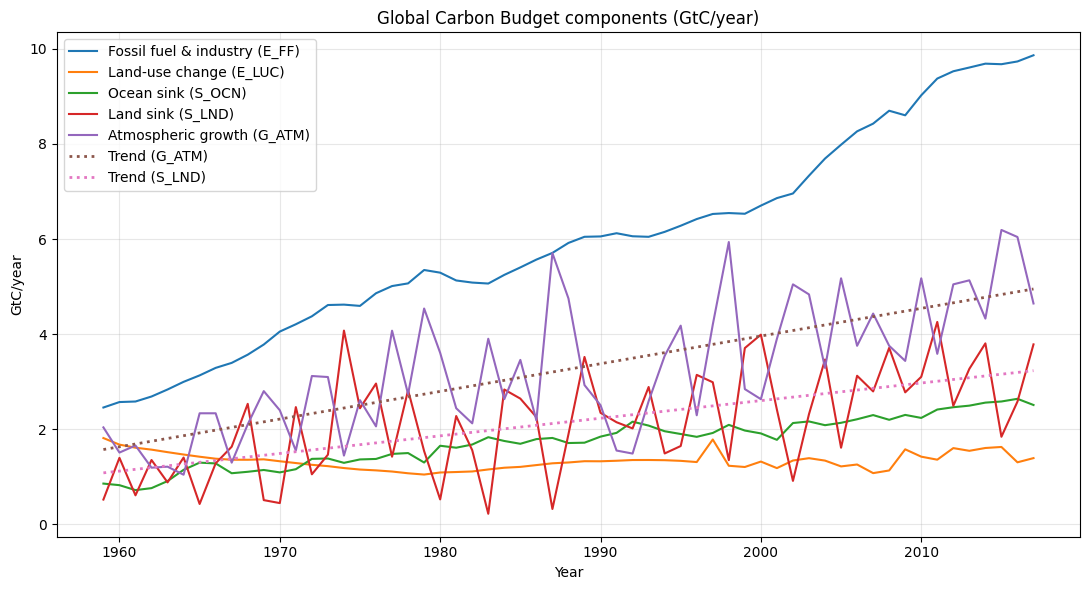

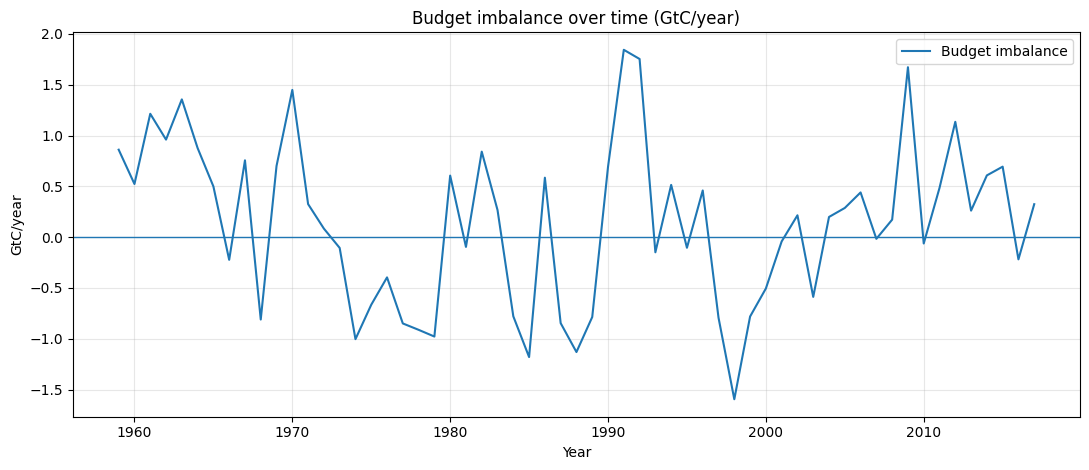

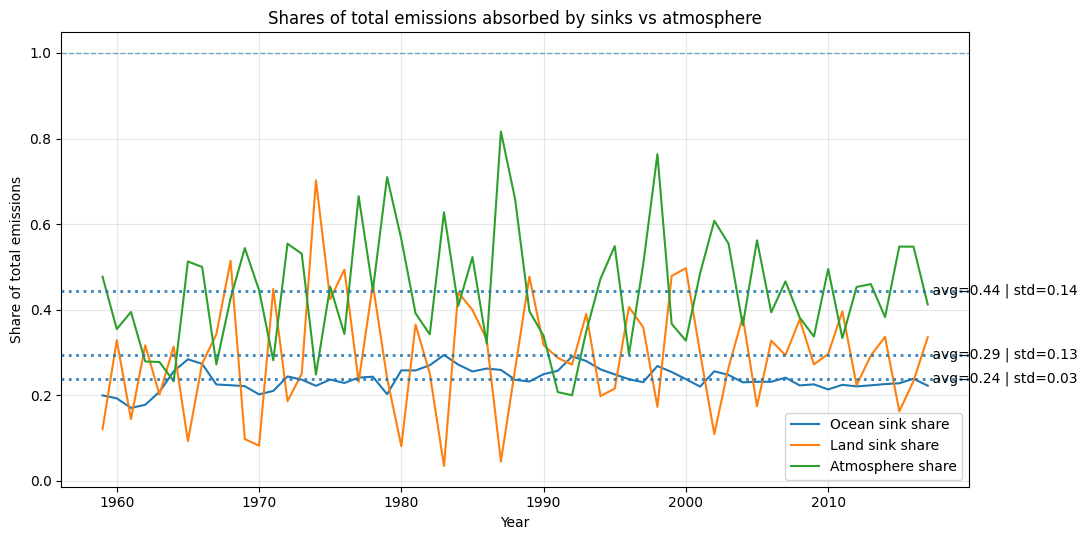

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
YEAR = "Year"
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"

# If you already computed IMB to match the dataset, keep it.
# Otherwise, define the imbalance consistent with the spreadsheet:
# imbalance = EFF + ELUC - SOCN - SLND - GATM
if "budget imbalance" in df_BUDGET.columns:
    IMB_COL = "budget imbalance"
else:
    df_BUDGET["budget imbalance"] = (
        df_BUDGET[EFF] + df_BUDGET[ELUC] - df_BUDGET[SOCN] - df_BUDGET[SLND] - df_BUDGET[GATM]
    )
    IMB_COL = "budget imbalance"

# Ensure sorted by year
df_BUDGET = df_BUDGET.sort_values(YEAR).reset_index(drop=True)

# ----------------------------
# Trend lines for G_ATM and S_LND
# ----------------------------
x = df_BUDGET[YEAR].values

# Linear trend for G_ATM
coef_gatm = np.polyfit(x, df_BUDGET[GATM].values, 1)
trend_gatm = np.polyval(coef_gatm, x)

# Linear trend for S_LND
coef_slnd = np.polyfit(x, df_BUDGET[SLND].values, 1)
trend_slnd = np.polyval(coef_slnd, x)

# ----------------------------
# 1) Plot: components over time
# ----------------------------
plt.figure(figsize=(11, 6))
plt.plot(df_BUDGET[YEAR], df_BUDGET[EFF],  label="Fossil fuel & industry (E_FF)")
plt.plot(df_BUDGET[YEAR], df_BUDGET[ELUC], label="Land-use change (E_LUC)")
plt.plot(df_BUDGET[YEAR], df_BUDGET[SOCN], label="Ocean sink (S_OCN)")
plt.plot(df_BUDGET[YEAR], df_BUDGET[SLND], label="Land sink (S_LND)")
plt.plot(df_BUDGET[YEAR], df_BUDGET[GATM], label="Atmospheric growth (G_ATM)")

# Dotted trends
plt.plot(df_BUDGET[YEAR], trend_gatm, linestyle=":", linewidth=2, label="Trend (G_ATM)")
plt.plot(df_BUDGET[YEAR], trend_slnd, linestyle=":", linewidth=2, label="Trend (S_LND)")

plt.title("Global Carbon Budget components (GtC/year)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# ----------------------------
# 2) Plot: budget imbalance over time
# ----------------------------
plt.figure(figsize=(11, 4.8))
plt.plot(df_BUDGET[YEAR], df_BUDGET[IMB_COL], label="Budget imbalance")

plt.axhline(0, linewidth=1)
plt.title("Budget imbalance over time (GtC/year)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ----------------------------
# 3) Plot: shares of total emissions
#    fraction of emissions going to:
#    - ocean sink
#    - land sink
#    - atmosphere
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt

total_emissions = df_BUDGET[EFF] + df_BUDGET[ELUC]
total_emissions = total_emissions.replace(0, np.nan)  # safety

df_BUDGET["share_ocean"] = df_BUDGET[SOCN] / total_emissions
df_BUDGET["share_land"]  = df_BUDGET[SLND] / total_emissions
df_BUDGET["share_atm"]   = df_BUDGET[GATM] / total_emissions

# ---- Means + STDs (ignore NaNs)
avg_ocean = df_BUDGET["share_ocean"].mean(skipna=True)
std_ocean = df_BUDGET["share_ocean"].std(skipna=True)

avg_land  = df_BUDGET["share_land"].mean(skipna=True)
std_land  = df_BUDGET["share_land"].std(skipna=True)

avg_atm   = df_BUDGET["share_atm"].mean(skipna=True)
std_atm   = df_BUDGET["share_atm"].std(skipna=True)

plt.figure(figsize=(11, 5.5))

# Main series
plt.plot(df_BUDGET[YEAR], df_BUDGET["share_ocean"], label="Ocean sink share")
plt.plot(df_BUDGET[YEAR], df_BUDGET["share_land"],  label="Land sink share")
plt.plot(df_BUDGET[YEAR], df_BUDGET["share_atm"],   label="Atmosphere share")

# Reference line
plt.axhline(1, linewidth=1, linestyle="--", alpha=0.6)

# ---- Mean lines (dotted)
plt.axhline(avg_ocean, linestyle=":", linewidth=2, alpha=0.9)
plt.axhline(avg_land,  linestyle=":", linewidth=2, alpha=0.9)
plt.axhline(avg_atm,   linestyle=":", linewidth=2, alpha=0.9)

# ---- Show mean + std values (right side)
x_text = df_BUDGET[YEAR].max()

plt.text(x_text, avg_ocean, f" avg={avg_ocean:.2f} | std={std_ocean:.2f}", va="center")
plt.text(x_text, avg_land,  f" avg={avg_land:.2f} | std={std_land:.2f}", va="center")
plt.text(x_text, avg_atm,   f" avg={avg_atm:.2f} | std={std_atm:.2f}", va="center")

plt.title("Shares of total emissions absorbed by sinks vs atmosphere")
plt.xlabel("Year")
plt.ylabel("Share of total emissions")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Check the imbalance for stationarity

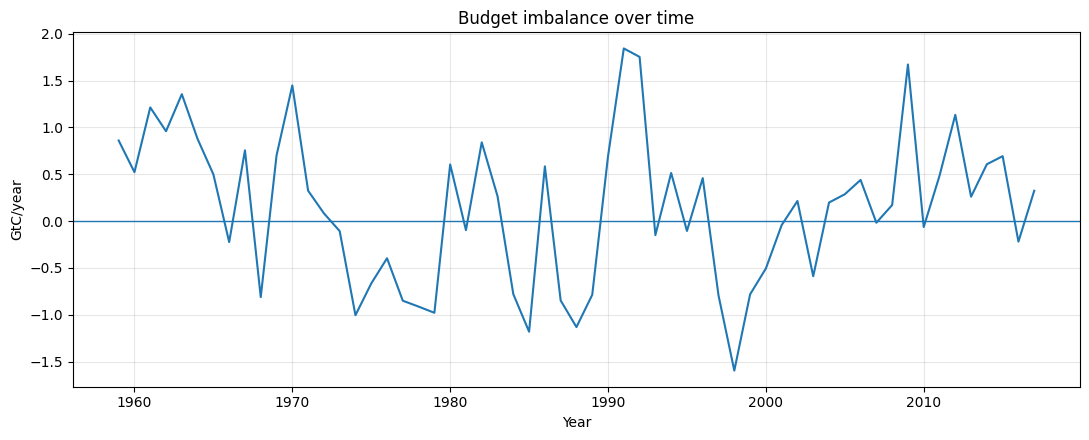

<Figure size 1100x450 with 0 Axes>

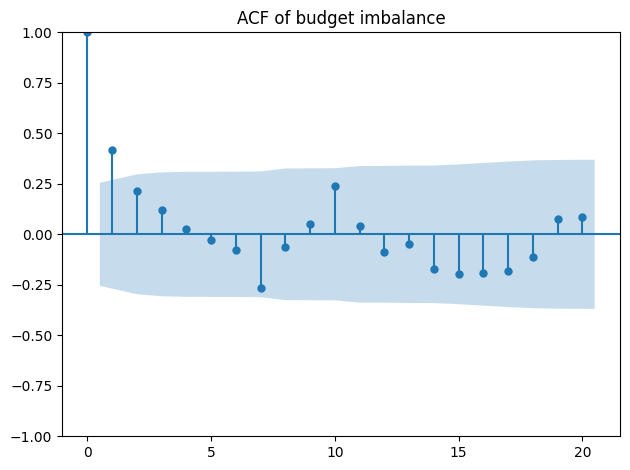

ADF test
  Test statistic: -4.8217
  p-value       : 0.0000
  Used lags     : 0
  N obs         : 58
  Critical values: {'1%': np.float64(-3.548493559596539), '5%': np.float64(-2.912836594776334), '10%': np.float64(-2.594129155766944)}

KPSS test
  Test statistic: 0.1498
  p-value       : 0.1000
  Used lags     : 3
  Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\zgcha\AppData\Local\Temp\ipykernel_94144\3220765521.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(imb, regression="c", nlags="auto")


In [9]:


# Pick the right column name
imb_col = "budget imbalance"  # change if yours is called "IMB"

imb = df_BUDGET[imb_col].dropna().astype(float)
years = df_BUDGET.loc[imb.index, "Year"]

# ----------------------------
# Quick plot
# ----------------------------
plt.figure(figsize=(11, 4.5))
plt.plot(years, imb)
plt.axhline(0, linewidth=1)
plt.title("Budget imbalance over time")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# ACF plot (detect persistence)
# ----------------------------
plt.figure(figsize=(11, 4.5))
plot_acf(imb, lags=20)
plt.title("ACF of budget imbalance")
plt.tight_layout()
plt.show()

# ----------------------------
# ADF test
# ----------------------------
adf_result = adfuller(imb, autolag="AIC")
print("ADF test")
print(f"  Test statistic: {adf_result[0]:.4f}")
print(f"  p-value       : {adf_result[1]:.4f}")
print(f"  Used lags     : {adf_result[2]}")
print(f"  N obs         : {adf_result[3]}")
print("  Critical values:", adf_result[4])
print()

# ----------------------------
# KPSS test
# ----------------------------
# regression='c' tests stationarity around a constant mean
kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(imb, regression="c", nlags="auto")
print("KPSS test")
print(f"  Test statistic: {kpss_stat:.4f}")
print(f"  p-value       : {kpss_p:.4f}")
print(f"  Used lags     : {kpss_lags}")
print("  Critical values:", kpss_crit)


In [10]:
import numpy as np

# Column names (adjust if yours differ)
EFF = "fossil fuel and industry"
ELUC = "land-use change emissions"
IMB = "budget imbalance"   # or "IMB" if you created that column

# Total emissions
df_BUDGET["E_total"] = df_BUDGET[EFF] + df_BUDGET[ELUC]

# Imbalance-to-emissions ratio (absolute)
df_BUDGET["imbalance_ratio"] = (df_BUDGET[IMB].abs() / df_BUDGET["E_total"]) * 100  # in %

# Quick summary stats
summary = df_BUDGET["imbalance_ratio"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
print("Imbalance-to-emissions ratio (%):")
print(summary)

# Key “headline” numbers
print("\nHeadline metrics:")
print(f"Mean ratio  : {df_BUDGET['imbalance_ratio'].mean():.2f}%")
print(f"Median ratio: {df_BUDGET['imbalance_ratio'].median():.2f}%")
print(f"Max ratio   : {df_BUDGET['imbalance_ratio'].max():.2f}%")

# Optional: show worst years
worst = df_BUDGET.loc[df_BUDGET["imbalance_ratio"].nlargest(5).index, ["Year", IMB, "E_total", "imbalance_ratio"]]
print("\nTop 5 worst years by imbalance ratio:")
print(worst.sort_values("imbalance_ratio", ascending=False))


Imbalance-to-emissions ratio (%):
count    59.000000
mean     10.357648
std       7.879682
min       0.176811
5%        1.300614
25%       3.704630
50%       9.491101
75%      15.495676
95%      24.951984
max      31.181999
Name: imbalance_ratio, dtype: float64

Headline metrics:
Mean ratio  : 10.36%
Median ratio: 9.49%
Max ratio   : 31.18%

Top 5 worst years by imbalance ratio:
    Year  budget imbalance   E_total  imbalance_ratio
4   1963          1.355333  4.346524        31.181999
2   1961          1.213762  4.187303        28.986728
11  1970          1.448736  5.374058        26.957944
32  1991          1.843398  7.454366        24.729100
33  1992          1.753073  7.405648        23.672111


<Axes: >

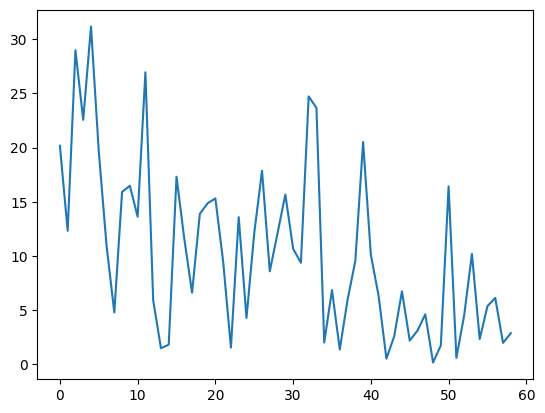

In [11]:
df_BUDGET["imbalance_ratio"].plot()

<Axes: >

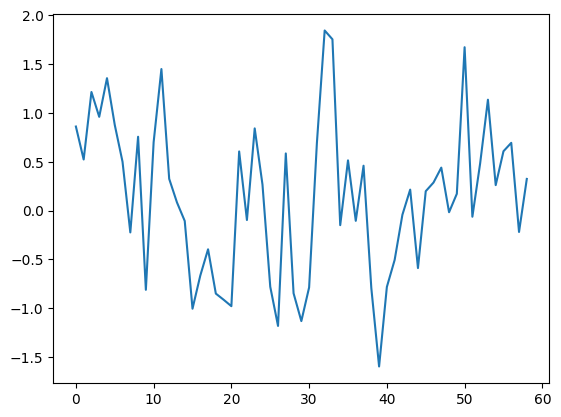

In [12]:
df_BUDGET[IMB].plot()

### 4.3 Correlation and lead/lag exploration


Q1) CORRELATIONS WITH SIGNED IMBALANCE:
land-use change emissions    0.430124
imb_ratio_pct                0.265024
E_total                      0.003625
fossil fuel and industry    -0.032443
ocean sink                  -0.044014
land sink                   -0.261914
atmospheric growth          -0.351010
Name: imb_signed, dtype: float64

Q1) CORRELATIONS WITH ABSOLUTE IMBALANCE:
imb_ratio_pct                0.892342
land-use change emissions    0.210970
land sink                   -0.179487
ocean sink                  -0.202866
E_total                     -0.210923
fossil fuel and industry    -0.229307
atmospheric growth          -0.244268
Name: imb_abs, dtype: float64


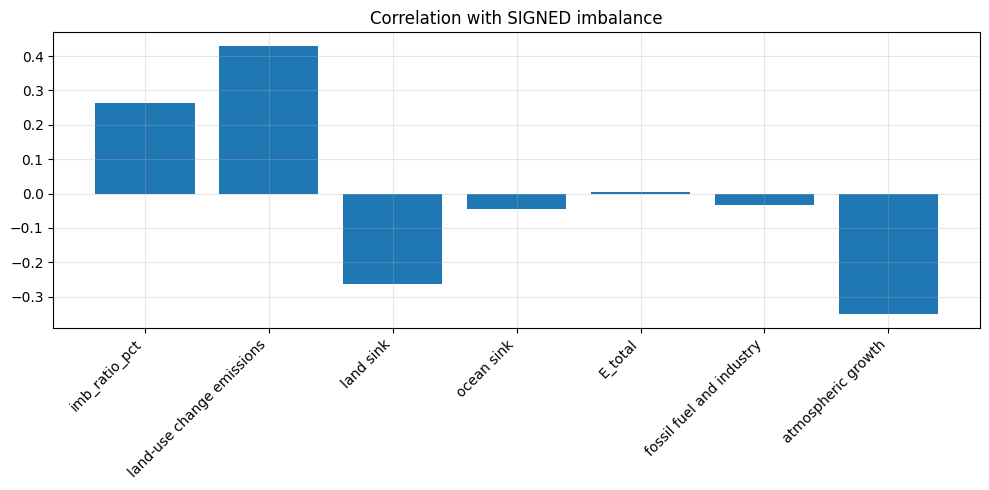

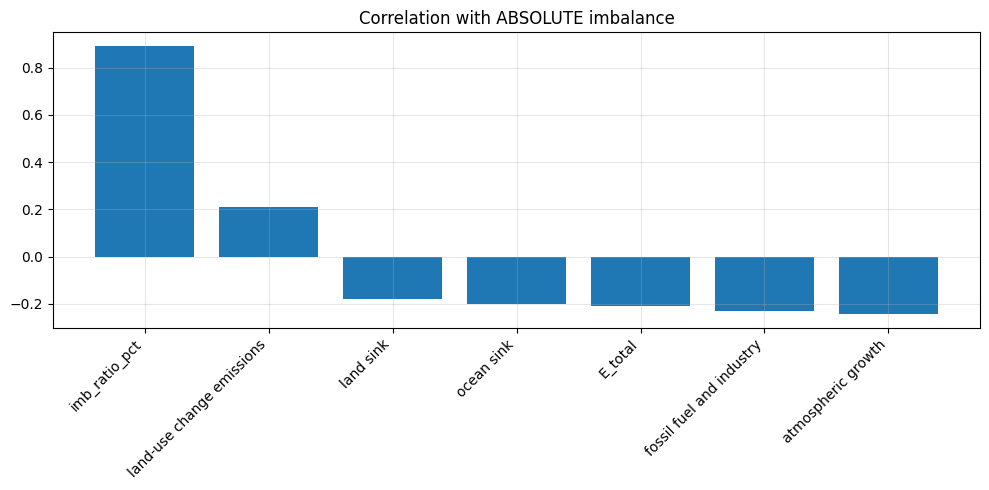


Q2) EARLY (1959–1988) period correlations (signed):
land-use change emissions    0.567474
imb_ratio_pct                0.350155
ocean sink                  -0.536983
atmospheric growth          -0.568769
land sink                   -0.591099
E_total                     -0.628054
fossil fuel and industry    -0.636177
Name: imb_signed, dtype: float64

Q2) EARLY (1959–1988) period correlations (abs):
imb_ratio_pct                0.927334
land-use change emissions    0.227438
land sink                   -0.020597
atmospheric growth          -0.035737
E_total                     -0.078426
fossil fuel and industry    -0.107315
ocean sink                  -0.255564
Name: imb_abs, dtype: float64

Q2) LATE  (1989–2017) period correlations (signed):
imb_ratio_pct                0.320137
ocean sink                   0.250530
land-use change emissions    0.230558
E_total                      0.207888
fossil fuel and industry     0.190091
land sink                   -0.101248
atmospheric growth   

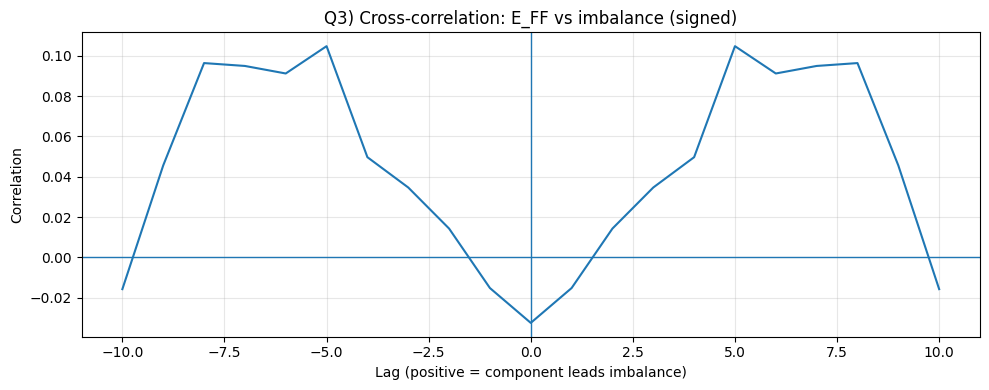

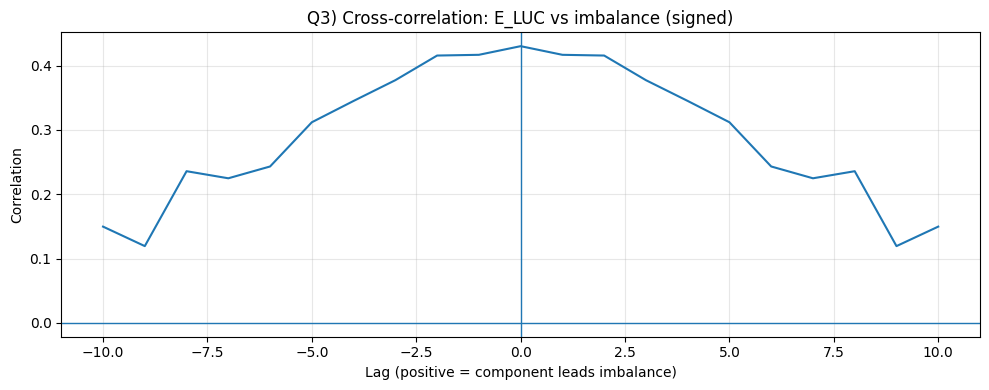

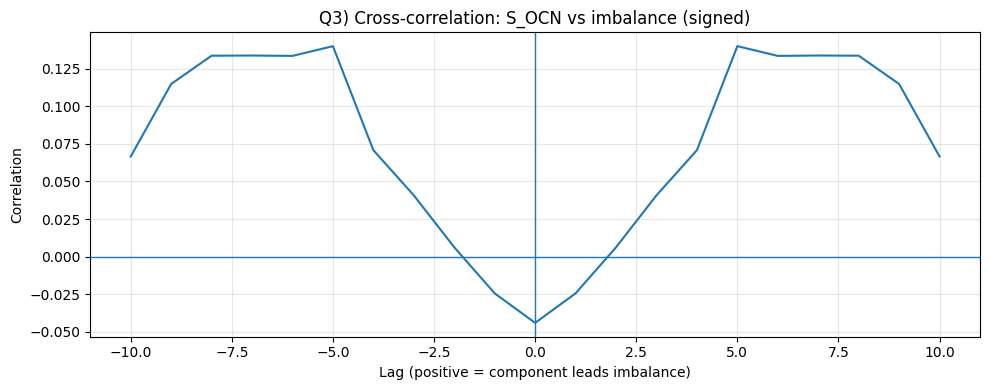

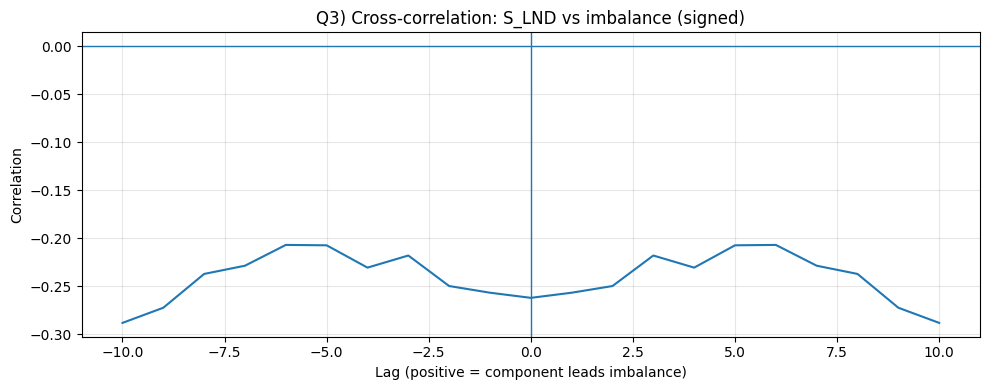

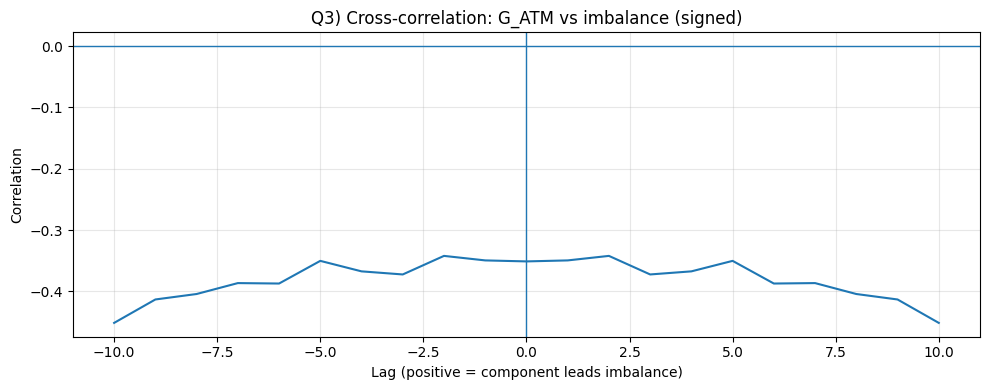

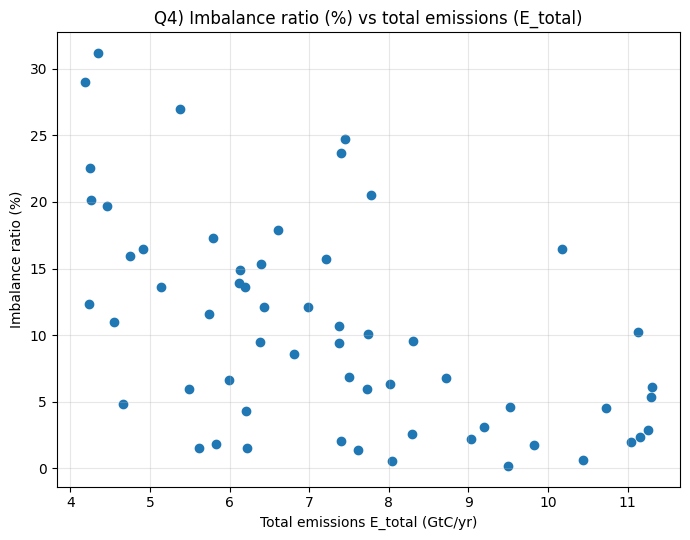


Q4) Corr(E_total, imbalance_ratio_pct) = -0.536


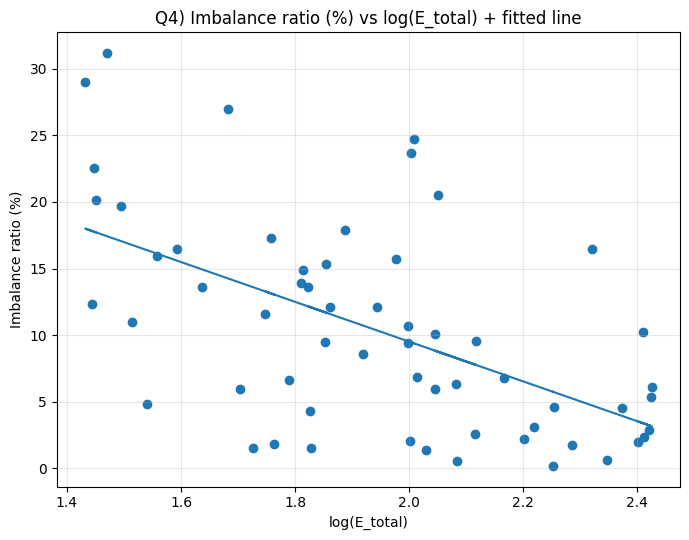

Q4) Fitted relation: ratio ≈ 39.40 + -14.94 * log(E_total)

Q5) Top 8 years by absolute imbalance:
    Year  imb_signed   imb_abs  imb_ratio_pct  fossil fuel and industry  \
32  1991    1.843398  1.843398      24.729100                  6.121555   
33  1992    1.753073  1.753073      23.672111                  6.057616   
50  2009    1.672046  1.672046      16.429750                  8.603478   
39  1998   -1.595605  1.595605      20.525859                  6.546120   
11  1970    1.448736  1.448736      26.957944                  4.051805   
4   1963    1.355333  1.355333      31.181999                  2.832715   
2   1961    1.213762  1.213762      28.986728                  2.579724   
26  1985   -1.180465  1.180465      17.870035                  5.401916   

    land-use change emissions  ocean sink  land sink  atmospheric growth  \
32                   1.332811    1.919818   2.143551              1.5476   
33                   1.348032    2.155372   2.013203              1.4840 

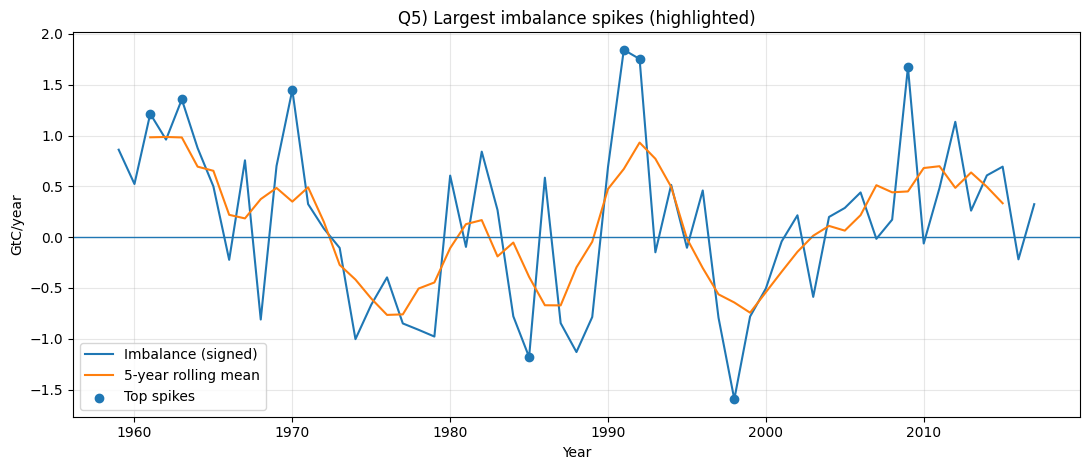

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Column names (edit if needed)
# ----------------------------
YEAR = "Year"
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
IMB  = "budget imbalance"   # signed imbalance (can be + or -)

# ----------------------------
# 1) Basic prep
# ----------------------------
df_BUDGET = df_BUDGET.sort_values(YEAR).reset_index(drop=True)

df_BUDGET["E_total"] = df_BUDGET[EFF] + df_BUDGET[ELUC]
df_BUDGET["imb_signed"] = df_BUDGET[IMB]
df_BUDGET["imb_abs"] = df_BUDGET[IMB].abs()
df_BUDGET["imb_ratio_pct"] = (df_BUDGET["imb_abs"] / df_BUDGET["E_total"]) * 100

# ==========================================================
# Q1) Correlations: signed vs absolute imbalance
# ==========================================================
components = [EFF, ELUC, SOCN, SLND, GATM, "E_total", "imb_ratio_pct"]

corr_signed = df_BUDGET[["imb_signed"] + components].corr().loc["imb_signed", components]
corr_abs    = df_BUDGET[["imb_abs"] + components].corr().loc["imb_abs", components]

print("\nQ1) CORRELATIONS WITH SIGNED IMBALANCE:")
print(corr_signed.sort_values(ascending=False))

print("\nQ1) CORRELATIONS WITH ABSOLUTE IMBALANCE:")
print(corr_abs.sort_values(ascending=False))

# Plot correlations side-by-side
corr_plot = pd.DataFrame({
    "corr_signed": corr_signed,
    "corr_abs": corr_abs
}).sort_values("corr_abs", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(corr_plot.index, corr_plot["corr_signed"].values)
plt.title("Correlation with SIGNED imbalance")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(corr_plot.index, corr_plot["corr_abs"].values)
plt.title("Correlation with ABSOLUTE imbalance")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ==========================================================
# Q2) Split sample: early vs late correlation structure
# ==========================================================
mid_year = int(df_BUDGET[YEAR].median())
df_early = df_BUDGET[df_BUDGET[YEAR] <= mid_year].copy()
df_late  = df_BUDGET[df_BUDGET[YEAR] > mid_year].copy()

def corr_summary(block, label):
    cs = block[["imb_signed"] + components].corr().loc["imb_signed", components]
    ca = block[["imb_abs"] + components].corr().loc["imb_abs", components]
    print(f"\nQ2) {label} period correlations (signed):")
    print(cs.sort_values(ascending=False))
    print(f"\nQ2) {label} period correlations (abs):")
    print(ca.sort_values(ascending=False))
    return cs, ca

cs_early, ca_early = corr_summary(df_early, f"EARLY ({df_early[YEAR].min()}–{df_early[YEAR].max()})")
cs_late,  ca_late  = corr_summary(df_late,  f"LATE  ({df_late[YEAR].min()}–{df_late[YEAR].max()})")

# Compare early vs late directly
compare_corr = pd.DataFrame({
    "signed_early": cs_early,
    "signed_late": cs_late,
    "abs_early": ca_early,
    "abs_late": ca_late,
})
compare_corr["delta_signed"] = compare_corr["signed_late"] - compare_corr["signed_early"]
compare_corr["delta_abs"] = compare_corr["abs_late"] - compare_corr["abs_early"]

print("\nQ2) Changes in correlation structure (late - early):")
print(compare_corr.sort_values("delta_abs", ascending=False))


# ==========================================================
# Q3) Cross-correlation (lead/lag relationships)
#     Positive lag = component leads imbalance (component at t-k vs IMB at t)
# ==========================================================
def cross_corr(series_x, series_y, max_lag=8):
    """
    Corr(x_{t-lag}, y_t) for lag in [-max_lag,...,+max_lag]
    Positive lag means x leads y.
    """
    out = {}
    x = series_x.reset_index(drop=True)
    y = series_y.reset_index(drop=True)

    for lag in range(-max_lag, max_lag+1):
        if lag < 0:
            # x lags y (x_{t+|lag|} with y_t)
            out[lag] = x[:lag].corr(y[-lag:])
        elif lag > 0:
            # x leads y (x_{t-lag} with y_t)
            out[lag] = x[lag:].corr(y[:-lag])
        else:
            out[lag] = x.corr(y)

    return pd.Series(out)

max_lag = 10
targets = {
    "E_FF": df_BUDGET[EFF],
    "E_LUC": df_BUDGET[ELUC],
    "S_OCN": df_BUDGET[SOCN],
    "S_LND": df_BUDGET[SLND],
    "G_ATM": df_BUDGET[GATM]
}

cc_results = {}
for name, ser in targets.items():
    cc = cross_corr(ser, df_BUDGET["imb_signed"], max_lag=max_lag)
    cc_results[name] = cc

cc_df = pd.DataFrame(cc_results)
print("\nQ3) Cross-correlations Corr(component_{t-lag}, imbalance_t):")
print(cc_df)

# Plot cross-correlations
for name in cc_df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(cc_df.index, cc_df[name])
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)
    plt.title(f"Q3) Cross-correlation: {name} vs imbalance (signed)")
    plt.xlabel("Lag (positive = component leads imbalance)")
    plt.ylabel("Correlation")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ==========================================================
# Q4) Denominator effect: relationship between ratio and E_total
# ==========================================================
plt.figure(figsize=(7, 5.5))
plt.scatter(df_BUDGET["E_total"], df_BUDGET["imb_ratio_pct"])
plt.title("Q4) Imbalance ratio (%) vs total emissions (E_total)")
plt.xlabel("Total emissions E_total (GtC/yr)")
plt.ylabel("Imbalance ratio (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation between denominator and ratio
corr_den = df_BUDGET["E_total"].corr(df_BUDGET["imb_ratio_pct"])
print(f"\nQ4) Corr(E_total, imbalance_ratio_pct) = {corr_den:.3f}")

# Fit simple log relationship (often better for denominator effects)
# ratio = a + b*log(E_total)
x = np.log(df_BUDGET["E_total"].replace(0, np.nan))
y = df_BUDGET["imb_ratio_pct"]
mask = x.notna() & y.notna()

b, a = np.polyfit(x[mask], y[mask], 1)  # y = a + b*x
y_hat = a + b*x[mask]

plt.figure(figsize=(7, 5.5))
plt.scatter(x[mask], y[mask])
plt.plot(x[mask], y_hat)
plt.title("Q4) Imbalance ratio (%) vs log(E_total) + fitted line")
plt.xlabel("log(E_total)")
plt.ylabel("Imbalance ratio (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Q4) Fitted relation: ratio ≈ {a:.2f} + {b:.2f} * log(E_total)")


# ==========================================================
# Q5) Largest spikes: which component “moves” in those years?
# ==========================================================
df_spikes = df_BUDGET[[YEAR, "imb_signed", "imb_abs", "imb_ratio_pct", EFF, ELUC, SOCN, SLND, GATM, "E_total"]].copy()
df_spikes_top = df_spikes.sort_values("imb_abs", ascending=False).head(8)

print("\nQ5) Top 8 years by absolute imbalance:")
print(df_spikes_top)

# Plot those years vs smoothed baseline for context
df_BUDGET["imb_roll5"] = df_BUDGET["imb_signed"].rolling(5, center=True).mean()

plt.figure(figsize=(11, 4.8))
plt.plot(df_BUDGET[YEAR], df_BUDGET["imb_signed"], label="Imbalance (signed)")
plt.plot(df_BUDGET[YEAR], df_BUDGET["imb_roll5"], label="5-year rolling mean")
plt.scatter(df_spikes_top[YEAR], df_spikes_top["imb_signed"], label="Top spikes", zorder=3)
plt.axhline(0, linewidth=1)
plt.title("Q5) Largest imbalance spikes (highlighted)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 5. Modelling

### 5.1 Baseline dynamic regressions (SARIMAX with AR(1) errors)


==== Ocean sink S_OCN dynamic regression (AR(1) errors) ====
                               SARIMAX Results                                
Dep. Variable:             ocean sink   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  25.160
Date:                Sun, 25 Jan 2026   AIC                            -42.319
Time:                        21:48:29   BIC                            -36.850
Sample:                             0   HQIC                           -40.606
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5020      0.169      2.971      0.003       0.171       0.833
E_total        0.1594      0.021      7.461      0.000       0.118   

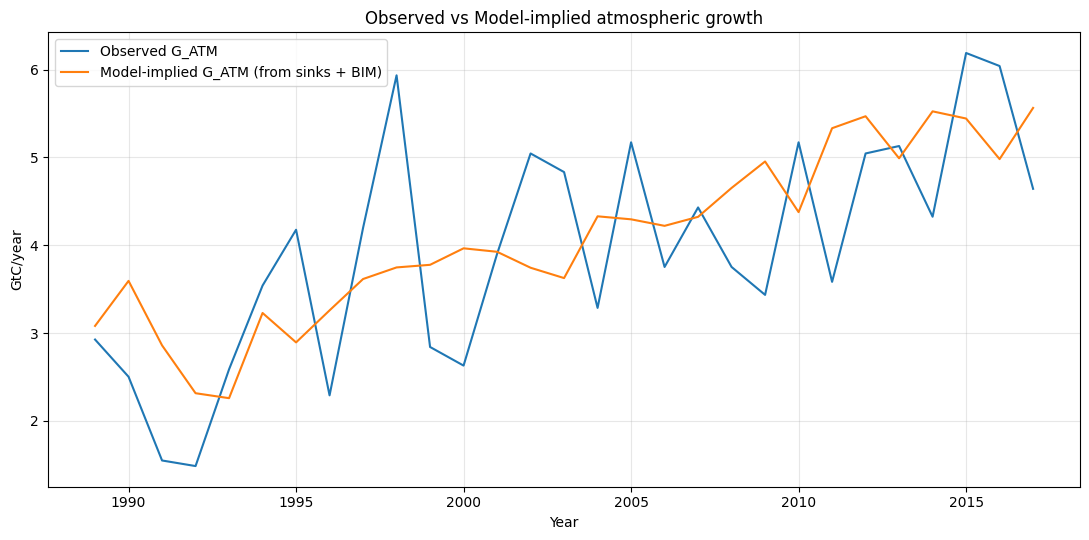

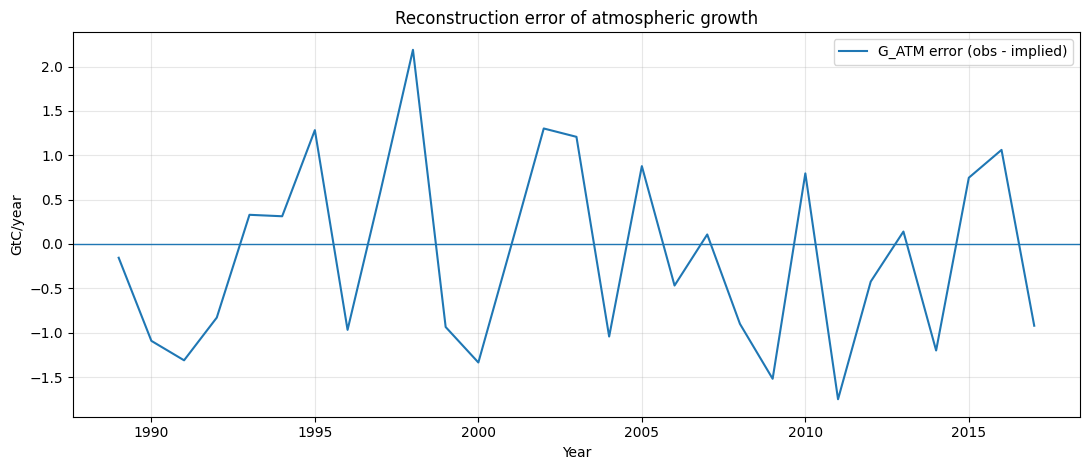

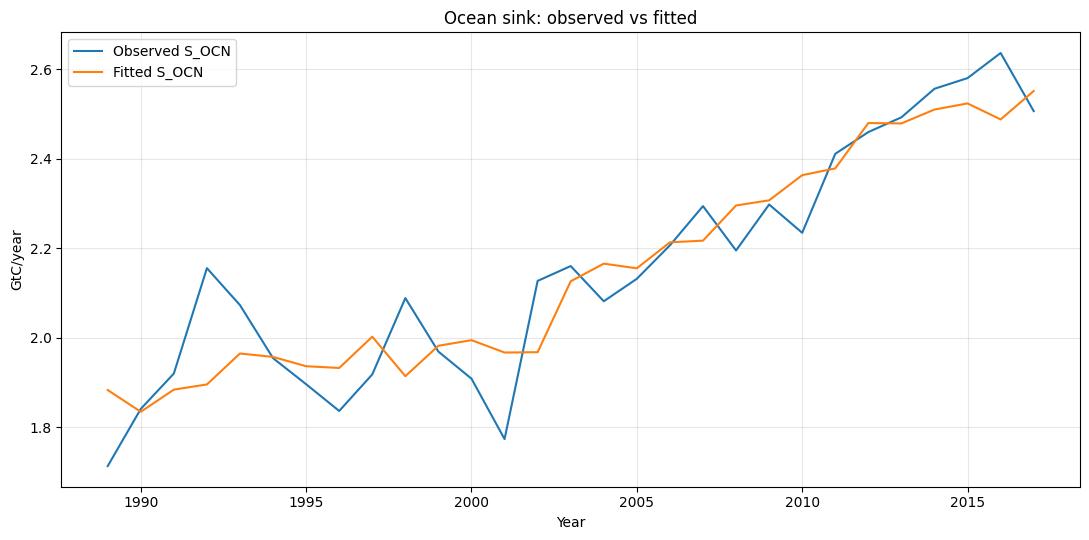

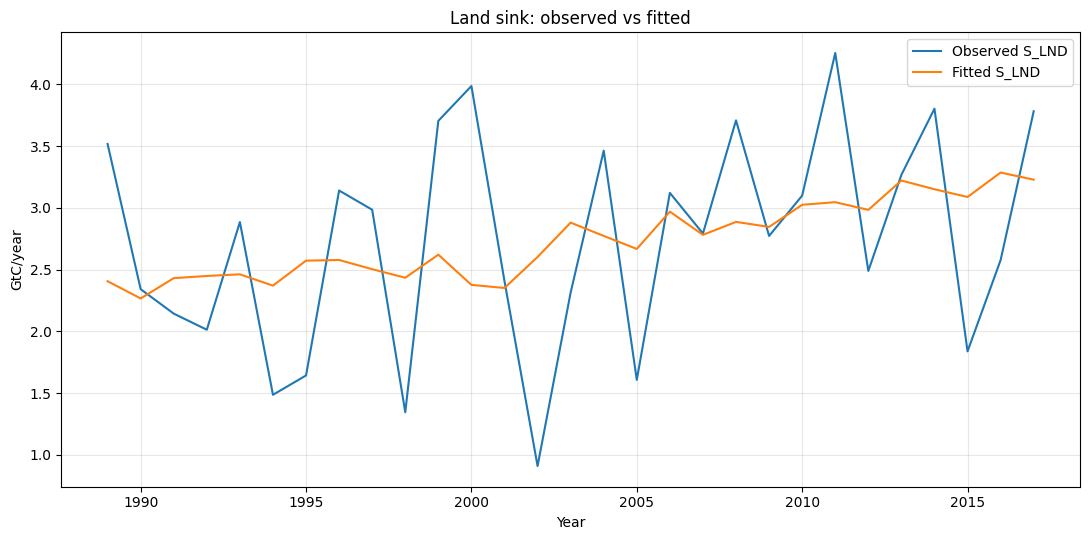

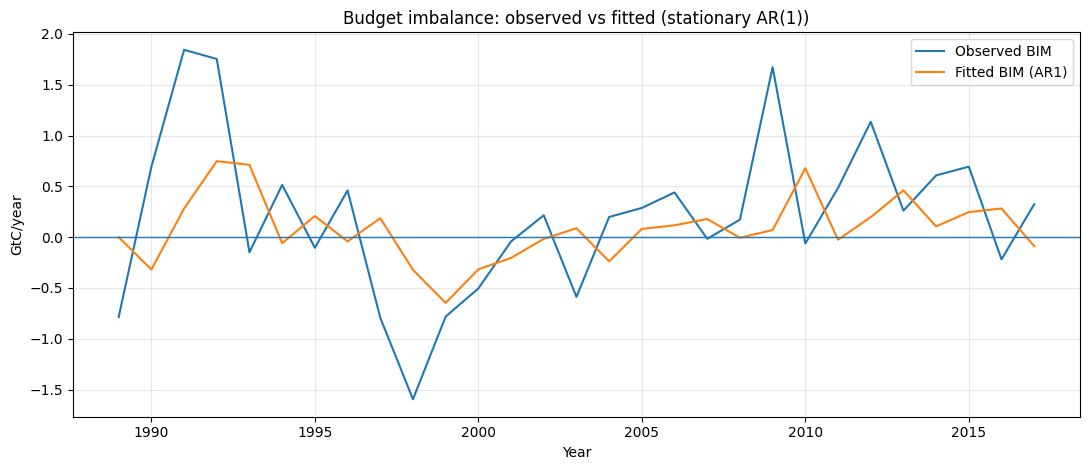

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ----------------------------
# Column names (edit if needed)
# ----------------------------
YEAR = "Year"
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"   # spreadsheet convention: E_total - sinks - GATM

# ----------------------------
# Helper: fit dynamic regression with AR(1) errors
# ----------------------------
def fit_sink_ar1(endog, exog, name="series"):
    """
    Model: endog_t = alpha + beta * exog_t + u_t
           u_t = rho * u_{t-1} + eps_t
    Implemented as SARIMAX with order=(1,0,0) and exog.
    """
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1, 0, 0),
        trend="c",              # intercept (alpha)
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res = model.fit(disp=False)
    print(f"\n==== {name} dynamic regression (AR(1) errors) ====")
    print(res.summary())
    return res

def fit_ar1(endog, name="series"):
    """
    Model: endog_t = rho * endog_{t-1} + eps_t
    Implemented as SARIMAX with order=(1,0,0), no exog.
    """
    model = SARIMAX(
        endog=endog,
        order=(1, 0, 0),
        trend="n",              # no intercept (imbalance should be around 0)
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res = model.fit(disp=False)
    print(f"\n==== {name} AR(1) ====")
    print(res.summary())
    return res


# ----------------------------
# 1) Prepare dataset
# ----------------------------
df = df_BUDGET.sort_values(YEAR).reset_index(drop=True).copy()
df["E_total"] = df[EFF] + df[ELUC]

# Optional: focus on late sample (recommended given your early/late diagnostics)
USE_LATE_SAMPLE = True
BREAK_YEAR = 1989

if USE_LATE_SAMPLE:
    df_model = df[df[YEAR] >= BREAK_YEAR].copy()
else:
    df_model = df.copy()

# Exogenous regressor: total emissions in levels (captures long-run scaling)
X = df_model[["E_total"]]

# ----------------------------
# 2) Fit sink equations (levels + variations)
# ----------------------------
res_ocn = fit_sink_ar1(df_model[SOCN], X, name="Ocean sink S_OCN")
res_lnd = fit_sink_ar1(df_model[SLND], X, name="Land sink S_LND")

# Get fitted values (in-sample)
df_model["S_OCN_hat"] = res_ocn.fittedvalues
df_model["S_LND_hat"] = res_lnd.fittedvalues

# ----------------------------
# 3) Fit imbalance as stationary AR(1)
# ----------------------------
res_bim = fit_ar1(df_model[BIM], name="Budget imbalance BIM")
df_model["BIM_hat"] = res_bim.fittedvalues

# ----------------------------
# 4) Reconstruct implied atmospheric growth
# ----------------------------
df_model["G_ATM_hat"] = (
    df_model["E_total"]
    - df_model["S_OCN_hat"]
    - df_model["S_LND_hat"]
    - df_model["BIM_hat"]
)

# ----------------------------
# 5) Evaluate fit vs observed G_ATM
# ----------------------------
df_model["G_ATM_obs"] = df_model[GATM]
df_model["G_ATM_err"] = df_model["G_ATM_obs"] - df_model["G_ATM_hat"]

rmse = np.sqrt(np.mean(df_model["G_ATM_err"]**2))
mae  = np.mean(np.abs(df_model["G_ATM_err"]))
corr = df_model["G_ATM_obs"].corr(df_model["G_ATM_hat"])

print("\n==== Derived G_ATM fit diagnostics ====")
print(f"RMSE: {rmse:.3f} GtC/yr")
print(f"MAE : {mae:.3f} GtC/yr")
print(f"Corr(observed, fitted): {corr:.3f}")

# ----------------------------
# 6) Plots: components + implied atmospheric growth
# ----------------------------
plt.figure(figsize=(11, 5.5))
plt.plot(df_model[YEAR], df_model["G_ATM_obs"], label="Observed G_ATM")
plt.plot(df_model[YEAR], df_model["G_ATM_hat"], label="Model-implied G_ATM (from sinks + BIM)")
plt.title("Observed vs Model-implied atmospheric growth")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4.8))
plt.plot(df_model[YEAR], df_model["G_ATM_err"], label="G_ATM error (obs - implied)")
plt.axhline(0, linewidth=1)
plt.title("Reconstruction error of atmospheric growth")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 5.5))
plt.plot(df_model[YEAR], df_model[SOCN], label="Observed S_OCN")
plt.plot(df_model[YEAR], df_model["S_OCN_hat"], label="Fitted S_OCN")
plt.title("Ocean sink: observed vs fitted")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 5.5))
plt.plot(df_model[YEAR], df_model[SLND], label="Observed S_LND")
plt.plot(df_model[YEAR], df_model["S_LND_hat"], label="Fitted S_LND")
plt.title("Land sink: observed vs fitted")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4.8))
plt.plot(df_model[YEAR], df_model[BIM], label="Observed BIM")
plt.plot(df_model[YEAR], df_model["BIM_hat"], label="Fitted BIM (AR1)")
plt.axhline(0, linewidth=1)
plt.title("Budget imbalance: observed vs fitted (stationary AR(1))")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### 5.2 Alternative specification / diagnostics (includes VIF)


==== Ocean sink: level + variation inputs ====
                               SARIMAX Results                                
Dep. Variable:             ocean sink   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  29.050
Date:                Sun, 25 Jan 2026   AIC                            -48.101
Time:                        21:48:34   BIC                            -41.264
Sample:                             0   HQIC                           -45.960
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5089      0.176      2.895      0.004       0.164       0.853
E_total        0.1678      0.023      7.268      0.000       0.123       0.213
dE_t

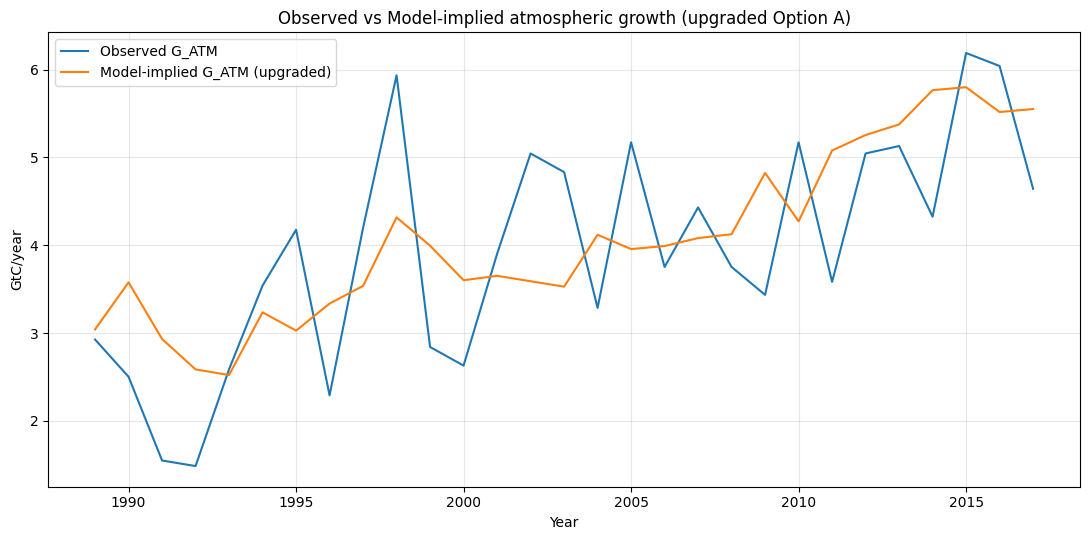

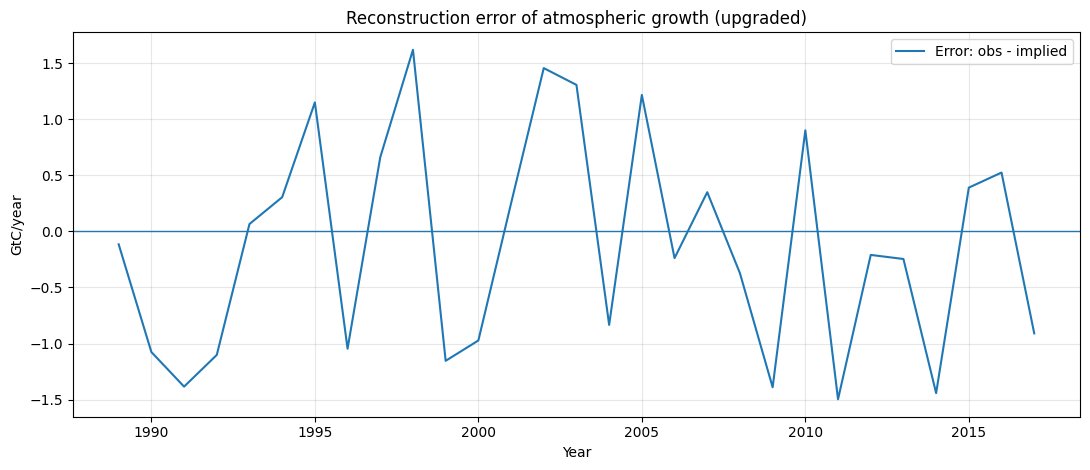

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

df = df_BUDGET.sort_values(YEAR).reset_index(drop=True).copy()
df["E_total"] = df[EFF] + df[ELUC]
df["dE_total"] = df["E_total"].diff()

# Late sample (as before)
BREAK_YEAR = 1989
df_model = df[df[YEAR] >= BREAK_YEAR].copy()

# Drop first row because diff creates NaN
df_model = df_model.dropna(subset=["dE_total"]).copy()

# Exog design:
# - Level: E_total
# - Variation: dE_total
# - Land-specific uncertainty: include ELUC explicitly
X_common = df_model[["E_total", "dE_total"]]
X_land   = df_model[["E_total", "dE_total", ELUC]]

def fit_dyn(endog, exog, name):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1,0,0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res = model.fit(disp=False)
    print(f"\n==== {name} ====")
    print(res.summary())
    return res

def fit_ar1(endog, name):
    model = SARIMAX(endog=endog, order=(1,0,0), trend="n",
                    enforce_stationarity=True, enforce_invertibility=True)
    res = model.fit(disp=False)
    print(f"\n==== {name} ====")
    print(res.summary())
    return res

# Fit sinks
res_ocn = fit_dyn(df_model[SOCN], X_common, "Ocean sink: level + variation inputs")
res_lnd = fit_dyn(df_model[SLND], X_land,   "Land sink: level + variation + ELUC")

df_model["S_OCN_hat"] = res_ocn.fittedvalues
df_model["S_LND_hat"] = res_lnd.fittedvalues

# Fit imbalance AR(1)
res_bim = fit_ar1(df_model[BIM], "Imbalance BIM: AR(1)")
df_model["BIM_hat"] = res_bim.fittedvalues

# Reconstruct implied G_ATM
df_model["G_ATM_hat"] = (
    df_model["E_total"]
    - df_model["S_OCN_hat"]
    - df_model["S_LND_hat"]
    - df_model["BIM_hat"]
)

# Diagnostics
df_model["G_ATM_err"] = df_model[GATM] - df_model["G_ATM_hat"]
rmse = np.sqrt(np.mean(df_model["G_ATM_err"]**2))
mae  = np.mean(np.abs(df_model["G_ATM_err"]))
corr = df_model[GATM].corr(df_model["G_ATM_hat"])

print("\n==== Derived G_ATM diagnostics (upgraded) ====")
print(f"RMSE: {rmse:.3f} GtC/yr")
print(f"MAE : {mae:.3f} GtC/yr")
print(f"Corr(observed, fitted): {corr:.3f}")

# Plot
plt.figure(figsize=(11, 5.5))
plt.plot(df_model[YEAR], df_model[GATM], label="Observed G_ATM")
plt.plot(df_model[YEAR], df_model["G_ATM_hat"], label="Model-implied G_ATM (upgraded)")
plt.title("Observed vs Model-implied atmospheric growth (upgraded Option A)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4.8))
plt.plot(df_model[YEAR], df_model["G_ATM_err"], label="Error: obs - implied")
plt.axhline(0, linewidth=1)
plt.title("Reconstruction error of atmospheric growth (upgraded)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_model[["E_total", "dE_total", ELUC]].copy()
X = X.dropna()
X["const"] = 1.0

vifs = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)
print(vifs)


E_total                       1.177724
dE_total                      1.195800
land-use change emissions     1.355861
const                        97.587732
dtype: float64


## 6. Robustness & model comparison

### 6.0 Sanity check: available columns

In [17]:
df_all.columns

Index(['Year', 'fossil fuel and industry', 'land-use change emissions',
       'atmospheric growth', 'ocean sink', 'land sink', 'budget imbalance',
       'nino34_mean', 'scpdsi_global_mean', 'tau_global_mean', 'DM_g_year',
       'nino34_mean_z', 'scpdsi_global_mean_z', 'tau_global_mean_z',
       'DM_g_year_z', 'E_total', 'dE_total'],
      dtype='str')

### 6.1 Two-window models (tau window vs fire window)


==== Ocean sink (1989–2012): E_total + dE_total ====
                               SARIMAX Results                                
Dep. Variable:             ocean sink   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  22.195
Date:                Sun, 25 Jan 2026   AIC                            -34.391
Time:                        21:48:44   BIC                            -28.501
Sample:                             0   HQIC                           -32.828
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5515      0.244      2.262      0.024       0.074       1.029
E_total        0.1599      0.034      4.638      0.000       0.092       0.22

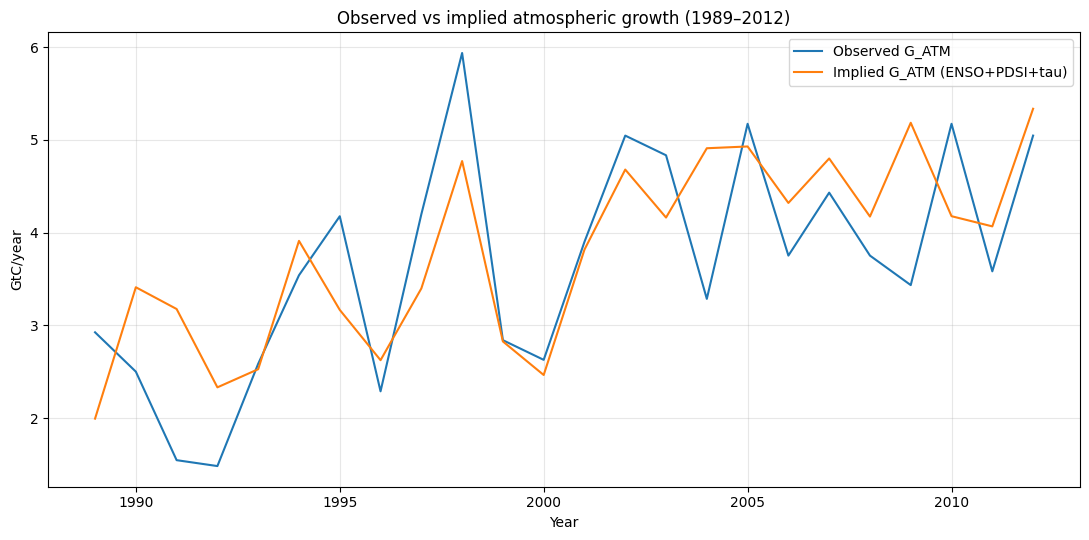


==== Ocean sink (1997–2017): E_total + dE_total ====
                               SARIMAX Results                                
Dep. Variable:             ocean sink   No. Observations:                   21
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  25.037
Date:                Sun, 25 Jan 2026   AIC                            -40.074
Time:                        21:48:44   BIC                            -34.851
Sample:                             0   HQIC                           -38.941
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6475      0.165      3.931      0.000       0.325       0.970
E_total        0.1746      0.016     11.248      0.000       0.144       0.20

c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


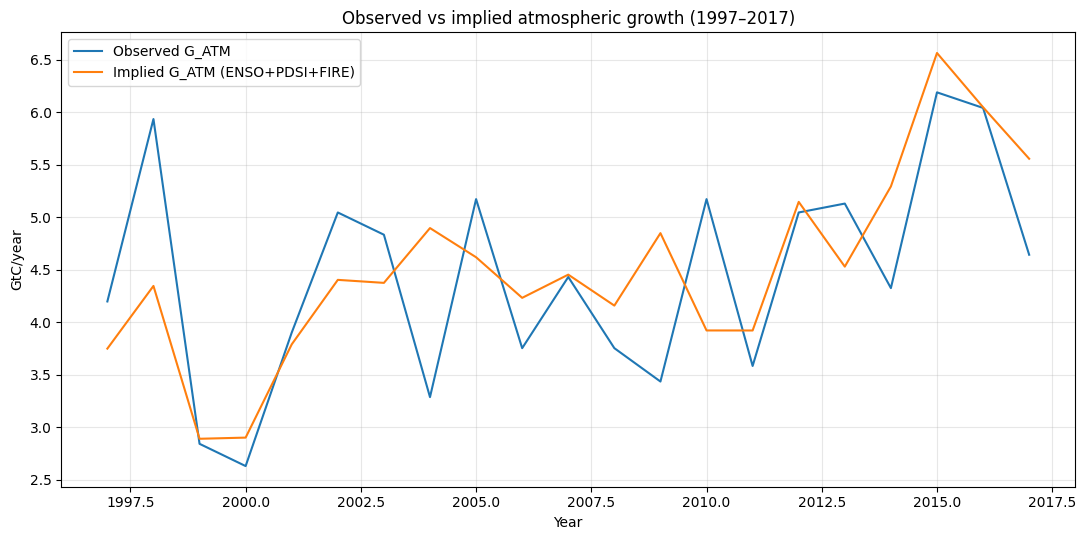

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

def fit_dyn(endog, exog, name):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1, 0, 0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res = model.fit(disp=False)
    print(f"\n==== {name} ====")
    print(res.summary())
    return res

def fit_ar1(endog, name):
    model = SARIMAX(
        endog=endog,
        order=(1, 0, 0),
        trend="n",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res = model.fit(disp=False)
    print(f"\n==== {name} ====")
    print(res.summary())
    return res

def eval_implied_gatm(df_m, label=""):
    df_m = df_m.copy()
    df_m["G_ATM_hat"] = df_m["E_total"] - df_m["S_OCN_hat"] - df_m["S_LND_hat"] - df_m["BIM_hat"]
    df_m["G_ATM_err"] = df_m[GATM] - df_m["G_ATM_hat"]

    rmse = np.sqrt(np.mean(df_m["G_ATM_err"]**2))
    mae  = np.mean(np.abs(df_m["G_ATM_err"]))
    corr = df_m[GATM].corr(df_m["G_ATM_hat"])

    print(f"\n==== Derived G_ATM diagnostics {label} ====")
    print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | Corr: {corr:.3f}")

    return df_m, (rmse, mae, corr)


# -------------------------
# MODEL 1: 1989–2012 (tau available)
# -------------------------
df_1 = df_all[(df_all["Year"] >= 1989) & (df_all["Year"] <= 2012)].copy()
df_1 = df_1.dropna(subset=["dE_total", "nino34_mean_z", "scpdsi_global_mean_z", "tau_global_mean_z"]).copy()

X_ocean_1 = df_1[["E_total", "dE_total"]]
X_land_1  = df_1[["E_total", "dE_total", "nino34_mean_z", "scpdsi_global_mean_z", "tau_global_mean_z"]]

res_ocn_1 = fit_dyn(df_1[SOCN], X_ocean_1, "Ocean sink (1989–2012): E_total + dE_total")
res_lnd_1 = fit_dyn(df_1[SLND], X_land_1,  "Land sink (1989–2012): + ENSO + PDSI + tau")

df_1["S_OCN_hat"] = res_ocn_1.fittedvalues
df_1["S_LND_hat"] = res_lnd_1.fittedvalues

res_bim_1 = fit_ar1(df_1[BIM], "Imbalance BIM (1989–2012): AR(1)")
df_1["BIM_hat"] = res_bim_1.fittedvalues

df_1, diag_1 = eval_implied_gatm(df_1, label="(1989–2012, ENSO+PDSI+tau)")

plt.figure(figsize=(11,5.5))
plt.plot(df_1[YEAR], df_1[GATM], label="Observed G_ATM")
plt.plot(df_1[YEAR], df_1["G_ATM_hat"], label="Implied G_ATM (ENSO+PDSI+tau)")
plt.title("Observed vs implied atmospheric growth (1989–2012)")
plt.xlabel("Year"); plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


# -------------------------
# MODEL 2: 1997–2017 (fire proxy available)
# -------------------------
df_2 = df_all[(df_all["Year"] >= 1997) & (df_all["Year"] <= 2017)].copy()
df_2 = df_2.dropna(subset=["dE_total", "nino34_mean_z", "scpdsi_global_mean_z", "DM_g_year_z"]).copy()

X_ocean_2 = df_2[["E_total", "dE_total"]]
X_land_2  = df_2[["E_total", "dE_total", "nino34_mean_z", "scpdsi_global_mean_z", "DM_g_year_z"]]

res_ocn_2 = fit_dyn(df_2[SOCN], X_ocean_2, "Ocean sink (1997–2017): E_total + dE_total")
res_lnd_2 = fit_dyn(df_2[SLND], X_land_2,  "Land sink (1997–2017): + ENSO + PDSI + FIRE")

df_2["S_OCN_hat"] = res_ocn_2.fittedvalues
df_2["S_LND_hat"] = res_lnd_2.fittedvalues

res_bim_2 = fit_ar1(df_2[BIM], "Imbalance BIM (1997–2017): AR(1)")
df_2["BIM_hat"] = res_bim_2.fittedvalues

df_2, diag_2 = eval_implied_gatm(df_2, label="(1997–2017, ENSO+PDSI+FIRE)")

plt.figure(figsize=(11,5.5))
plt.plot(df_2[YEAR], df_2[GATM], label="Observed G_ATM")
plt.plot(df_2[YEAR], df_2["G_ATM_hat"], label="Implied G_ATM (ENSO+PDSI+FIRE)")
plt.title("Observed vs implied atmospheric growth (1997–2017)")
plt.xlabel("Year"); plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


### 6.2 Robustness grid search over Niño / PDSI statistics (tau window)

In [20]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

# -------- helpers --------
def fit_dyn(endog, exog):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1,0,0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def fit_ar1(endog):
    model = SARIMAX(
        endog=endog,
        order=(1,0,0),
        trend="n",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def run_optionA(df_window, land_driver_cols, label=""):
    """
    Option A:
      S_OCN_t  = a0 + a1*E_total_t + a2*dE_total_t + u_t (AR1)
      S_LND_t  = b0 + b1*E_total_t + b2*dE_total_t + drivers + v_t (AR1)
      BIM_t    = AR1
      Implied G_ATM_hat = E_total - S_OCN_hat - S_LND_hat - BIM_hat
    """
    df_m = df_window.copy()

    need_cols = ["E_total", "dE_total", SOCN, SLND, BIM, GATM] + land_driver_cols
    df_m = df_m.dropna(subset=need_cols).copy()

    # Ocean exog
    X_ocean = df_m[["E_total", "dE_total"]]

    # Land exog
    X_land = df_m[["E_total", "dE_total"] + land_driver_cols]

    # Fit
    res_ocn = fit_dyn(df_m[SOCN], X_ocean)
    res_lnd = fit_dyn(df_m[SLND], X_land)
    res_bim = fit_ar1(df_m[BIM])

    df_m["S_OCN_hat"] = res_ocn.fittedvalues
    df_m["S_LND_hat"] = res_lnd.fittedvalues
    df_m["BIM_hat"]   = res_bim.fittedvalues

    # Identity reconstruction
    df_m["G_ATM_hat"] = df_m["E_total"] - df_m["S_OCN_hat"] - df_m["S_LND_hat"] - df_m["BIM_hat"]
    df_m["G_ATM_err"] = df_m[GATM] - df_m["G_ATM_hat"]

    rmse = float(np.sqrt(np.mean(df_m["G_ATM_err"]**2)))
    mae  = float(np.mean(np.abs(df_m["G_ATM_err"])))
    corr = float(df_m[GATM].corr(df_m["G_ATM_hat"]))

    # Pull coefficients of interest from land equation
    land_params = res_lnd.params

    out = {
        "spec": label,
        "n_obs": len(df_m),
        "rmse": rmse,
        "mae": mae,
        "corr": corr,
        # key land driver coefs
        **{f"coef_{c}": float(land_params.get(c, np.nan)) for c in land_driver_cols}
    }
    return out


# ------------------------------
# Choose robustness window
# (1989–2012 recommended because tau exists)
# ------------------------------
df_win = df_all[(df_all["Year"] >= 1989) & (df_all["Year"] <= 2012)].copy()

# ------------------------------
# Robustness specs:
# swap Niño statistic and PDSI statistic
# (drivers already z-scored / logz)
# ------------------------------
NINO_CHOICES = {
    "nino_mean": "nino34_mean_z",
    "nino_max":  "nino34_max_z",
    "nino_var":  "nino34_var_logz"
}

PDSI_CHOICES = {
    "pdsi_mean": "scpdsi_global_mean_z",
    "pdsi_max":  "scpdsi_global_max_z",
    "pdsi_var":  "scpdsi_global_var_logz"
}

TAU_BASE = "tau_global_mean_z"   # keep tau fixed for this window

results = []

for nino_name, nino_col in NINO_CHOICES.items():
    for pdsi_name, pdsi_col in PDSI_CHOICES.items():
        drivers = [nino_col, pdsi_col, TAU_BASE]
        label = f"{nino_name} + {pdsi_name} + tau_mean"
        out = run_optionA(df_win, drivers, label=label)
        results.append(out)

robust_table = pd.DataFrame(results).sort_values("corr", ascending=False)

# ------------------------------
# Display clean ranking table
# ------------------------------
display_cols = ["spec", "n_obs", "rmse", "mae", "corr"] + \
               [c for c in robust_table.columns if c.startswith("coef_")]

print(robust_table[display_cols].to_string(index=False))


KeyError: ['scpdsi_global_max_z']

### 6.3 Head-to-head comparison: emissions-only vs climate specs (tau window)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

def fit_dyn(endog, exog):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1,0,0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def fit_ar1(endog):
    model = SARIMAX(
        endog=endog,
        order=(1,0,0),
        trend="n",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def implied_GATM(df_window, land_driver_cols, label=""):
    """
    Returns dataframe with G_ATM_hat and metrics for a given land driver spec.
    Ocean always uses [E_total, dE_total].
    Land uses [E_total, dE_total] + drivers.
    BIM uses AR(1).
    """
    df_m = df_window.copy()

    need_cols = ["E_total", "dE_total", SOCN, SLND, BIM, GATM] + land_driver_cols
    df_m = df_m.dropna(subset=need_cols).copy()

    # ocean sink model
    X_ocean = df_m[["E_total", "dE_total"]]
    res_ocn = fit_dyn(df_m[SOCN], X_ocean)
    df_m["S_OCN_hat"] = res_ocn.fittedvalues

    # land sink model
    X_land = df_m[["E_total", "dE_total"] + land_driver_cols]
    res_lnd = fit_dyn(df_m[SLND], X_land)
    df_m["S_LND_hat"] = res_lnd.fittedvalues

    # imbalance AR(1)
    res_bim = fit_ar1(df_m[BIM])
    df_m["BIM_hat"] = res_bim.fittedvalues

    # implied atmospheric growth
    df_m["G_ATM_hat"] = df_m["E_total"] - df_m["S_OCN_hat"] - df_m["S_LND_hat"] - df_m["BIM_hat"]
    df_m["G_ATM_err"] = df_m[GATM] - df_m["G_ATM_hat"]

    rmse = float(np.sqrt(np.mean(df_m["G_ATM_err"]**2)))
    mae  = float(np.mean(np.abs(df_m["G_ATM_err"])))
    corr = float(df_m[GATM].corr(df_m["G_ATM_hat"]))

    metrics = {"label": label, "n_obs": len(df_m), "rmse": rmse, "mae": mae, "corr": corr}
    return df_m[[YEAR, GATM, "G_ATM_hat"]].copy(), metrics


# -------------------------------------------------
# Window: 1989–2012 (tau exists)
# -------------------------------------------------
df_8912 = df_all[(df_all[YEAR] >= 1989) & (df_all[YEAR] <= 2012)].copy()

# --- 1) emissions-only baseline (land has NO climate drivers)
df_base, m_base = implied_GATM(df_8912, land_driver_cols=[], label="Emissions-only baseline")

# --- 2) best climate spec (from robustness)
best_cols = ["nino34_max_z", "scpdsi_global_max_z", "tau_global_mean_z"]
df_best, m_best = implied_GATM(df_8912, land_driver_cols=best_cols,
                               label="Best climate: nino_max + pdsi_max + tau_mean")

# --- 3) optional: your earlier mean/mean/tau model
mid_cols = ["nino34_mean_z", "scpdsi_global_mean_z", "tau_global_mean_z"]
df_mid, m_mid = implied_GATM(df_8912, land_driver_cols=mid_cols,
                             label="Climate baseline: nino_mean + pdsi_mean + tau_mean")


# -------------------------------------------------
# Merge series for plotting
# -------------------------------------------------
plot_df = df_base.merge(df_best[[YEAR, "G_ATM_hat"]], on=YEAR, how="inner", suffixes=("_base", "_best"))
plot_df = plot_df.merge(df_mid[[YEAR, "G_ATM_hat"]], on=YEAR, how="inner")
plot_df = plot_df.rename(columns={"G_ATM_hat": "G_ATM_hat_mid"})

# -------------------------------------------------
# Print headline metrics (so you can quote them)
# -------------------------------------------------
print("=== MODEL COMPARISON (1989–2012) ===")
for m in [m_base, m_mid, m_best]:
    print(f"{m['label']:45s} | Corr={m['corr']:.3f}  RMSE={m['rmse']:.3f}  MAE={m['mae']:.3f}  N={m['n_obs']}")

# -------------------------------------------------
# Plot 1: observed vs implied overlays
# -------------------------------------------------
plt.figure(figsize=(12, 5.6))
plt.plot(plot_df[YEAR], plot_df[GATM], label="Observed G_ATM", linewidth=2)
plt.plot(plot_df[YEAR], plot_df["G_ATM_hat_base"], label=f"Implied (emissions-only)  corr={m_base['corr']:.2f}")
plt.plot(plot_df[YEAR], plot_df["G_ATM_hat_mid"],  label=f"Implied (mean/mean/tau)  corr={m_mid['corr']:.2f}")
plt.plot(plot_df[YEAR], plot_df["G_ATM_hat_best"], label=f"Implied (BEST climate)   corr={m_best['corr']:.2f}")

plt.title("Observed vs model-implied atmospheric growth (1989–2012)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot 2: improvement visualization (error comparison)
# -------------------------------------------------
plot_df["err_base"] = plot_df[GATM] - plot_df["G_ATM_hat_base"]
plot_df["err_best"] = plot_df[GATM] - plot_df["G_ATM_hat_best"]

plt.figure(figsize=(12, 4.8))
plt.plot(plot_df[YEAR], plot_df["err_base"], label="Error: emissions-only")
plt.plot(plot_df[YEAR], plot_df["err_best"], label="Error: BEST climate")
plt.axhline(0, linewidth=1)
plt.title("Reconstruction errors: emissions-only vs best climate model (1989–2012)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: ['nino34_max_z', 'scpdsi_global_max_z']

## 7. Appendix — scratch / alternative cells (kept verbatim)
These cells are earlier iterations / duplicates kept so no work is lost.

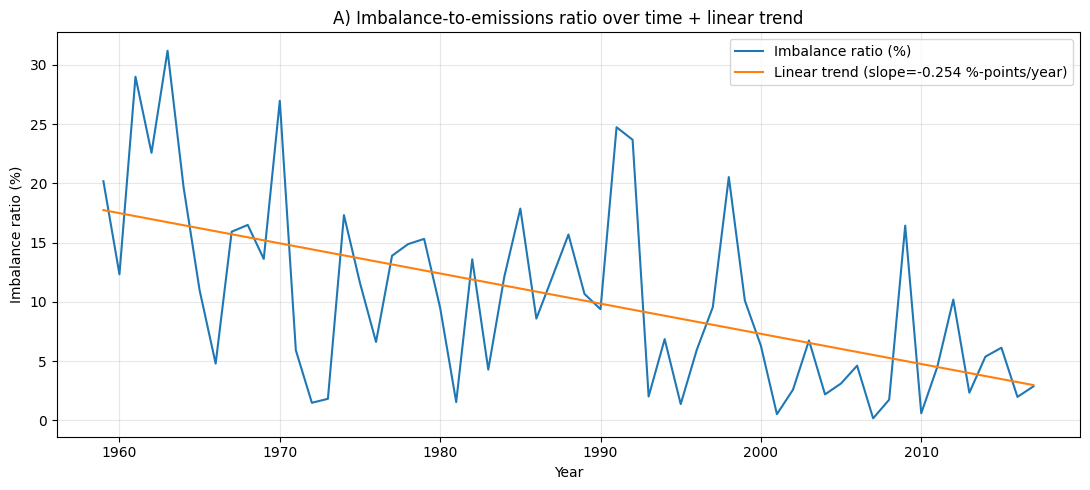

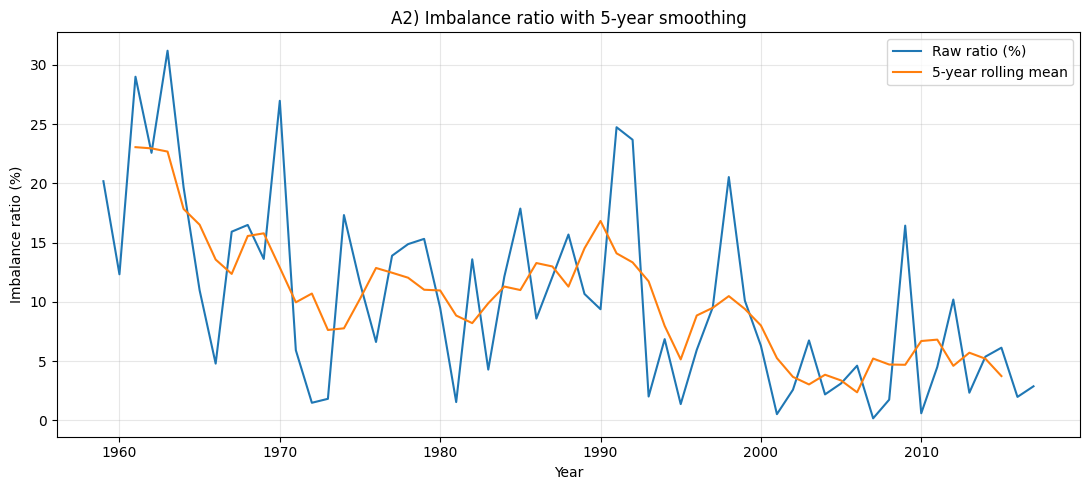

Linear trend slope in imbalance ratio: -0.2544 %-points per year


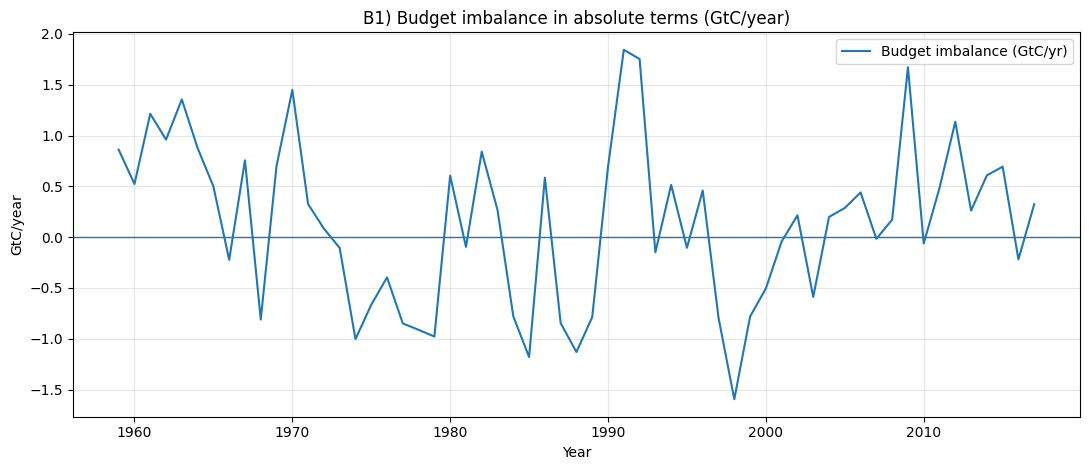

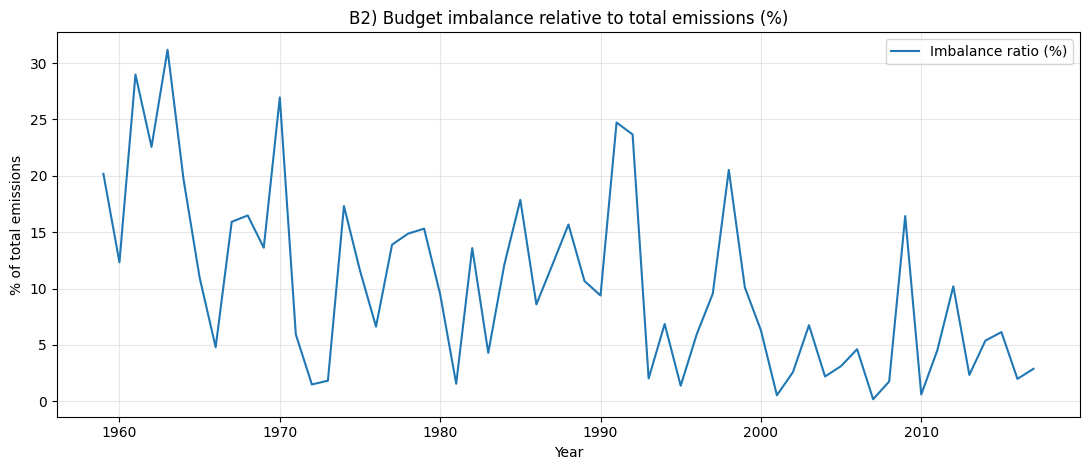


C) Correlation matrix (key rows shown):
fossil fuel and industry    -0.032443
land-use change emissions    0.430124
ocean sink                  -0.044014
land sink                   -0.261914
atmospheric growth          -0.351010
E_total                      0.003625
imb_ratio_pct                0.265024
Name: budget imbalance, dtype: float64


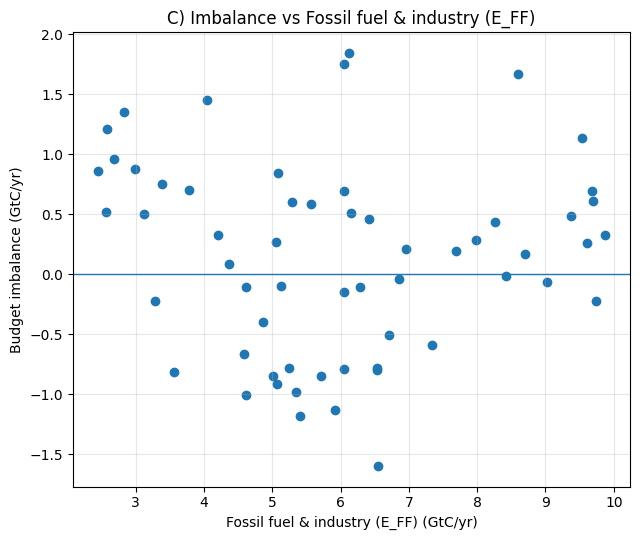

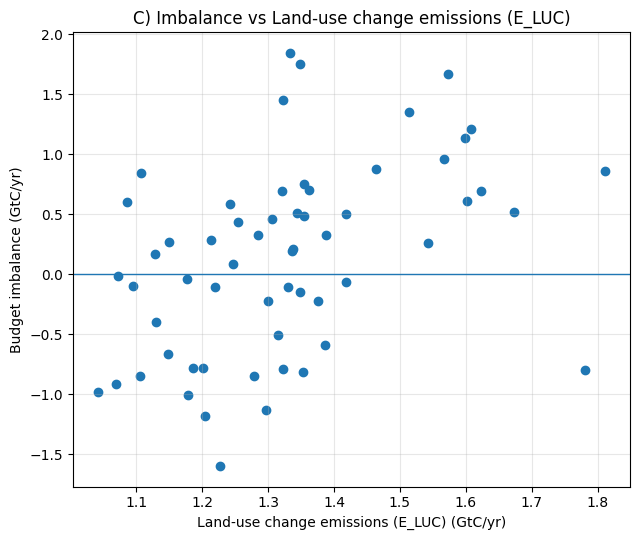

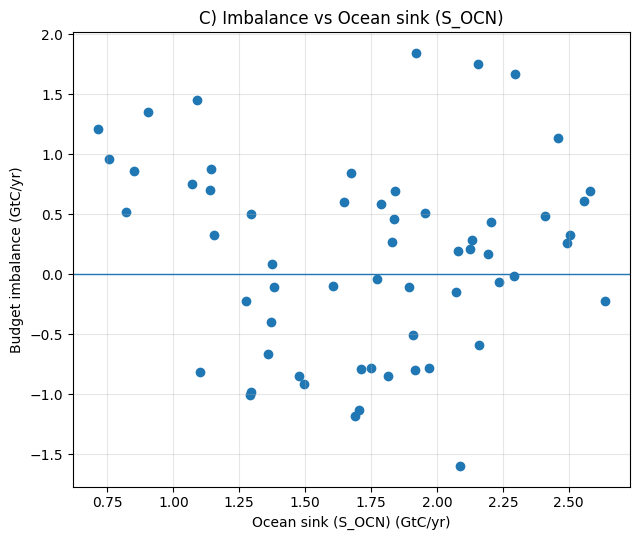

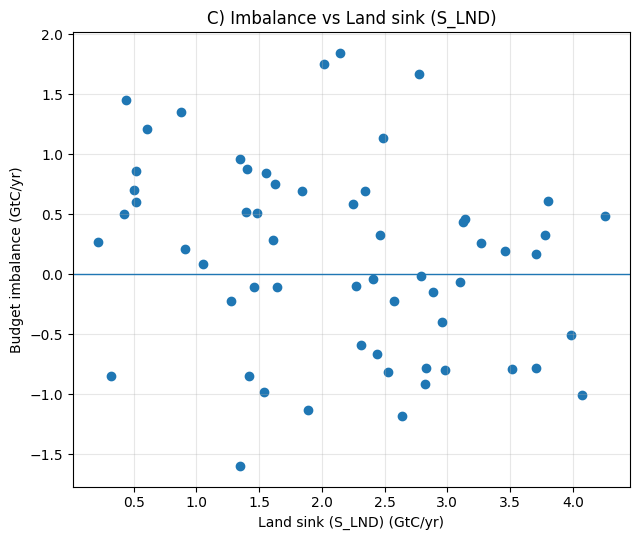

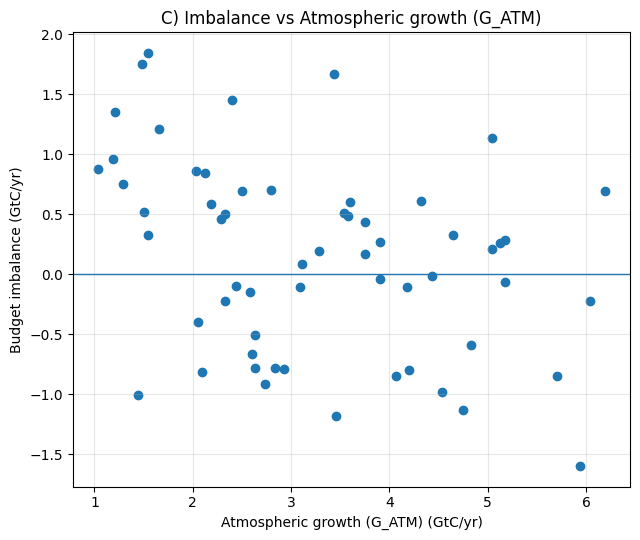


EARLY period summary (1959–1988):
  mean E_total      = 5.58 GtC/yr
  mean |imbalance|  = 0.73 GtC/yr
  mean ratio        = 13.59 %
  median ratio      = 13.61 %
  95% ratio         = 28.07 %

LATE period summary (1989–2017):
  mean E_total      = 9.05 GtC/yr
  mean |imbalance|  = 0.60 GtC/yr
  mean ratio        = 7.01 %
  median ratio      = 5.38 %
  95% ratio         = 22.41 %


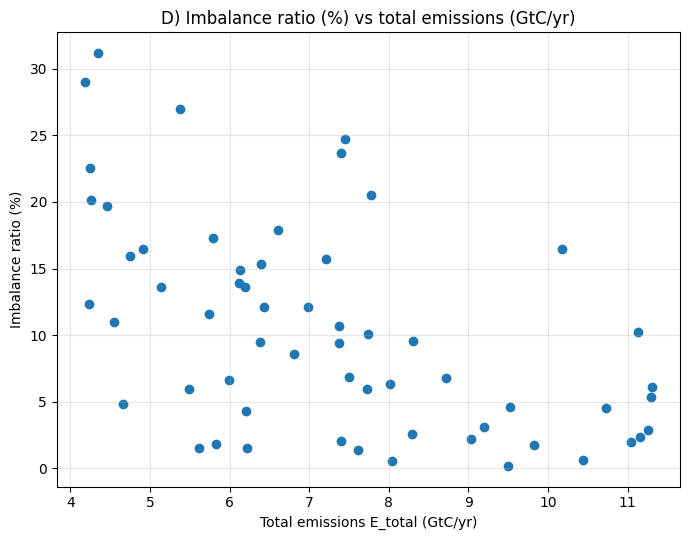

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Column names (edit if needed)
YEAR = "Year"
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
IMB  = "budget imbalance"   # or "IMB" if you computed it

# ---- Ensure sorted
df_BUDGET = df_BUDGET.sort_values(YEAR).reset_index(drop=True)

# ---- Total emissions + ratios
df_BUDGET["E_total"] = df_BUDGET[EFF] + df_BUDGET[ELUC]
df_BUDGET["imb_abs"] = df_BUDGET[IMB].abs()
df_BUDGET["imb_ratio_pct"] = (df_BUDGET["imb_abs"] / df_BUDGET["E_total"]) * 100

# ======================================================================================
# A) Does imbalance ratio trend downward over time?
# ======================================================================================
x = df_BUDGET[YEAR].astype(float).values
y = df_BUDGET["imb_ratio_pct"].astype(float).values

# Simple linear trend slope (OLS via numpy polyfit)
slope, intercept = np.polyfit(x, y, 1)
trendline = slope * x + intercept

plt.figure(figsize=(11, 5))
plt.plot(df_BUDGET[YEAR], df_BUDGET["imb_ratio_pct"], label="Imbalance ratio (%)")
plt.plot(df_BUDGET[YEAR], trendline, label=f"Linear trend (slope={slope:.3f} %-points/year)")
plt.title("A) Imbalance-to-emissions ratio over time + linear trend")
plt.xlabel("Year")
plt.ylabel("Imbalance ratio (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Rolling mean (5-year) to visualize trend better
df_BUDGET["imb_ratio_roll5"] = df_BUDGET["imb_ratio_pct"].rolling(5, center=True).mean()

plt.figure(figsize=(11, 5))
plt.plot(df_BUDGET[YEAR], df_BUDGET["imb_ratio_pct"], label="Raw ratio (%)")
plt.plot(df_BUDGET[YEAR], df_BUDGET["imb_ratio_roll5"], label="5-year rolling mean")
plt.title("A2) Imbalance ratio with 5-year smoothing")
plt.xlabel("Year")
plt.ylabel("Imbalance ratio (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Linear trend slope in imbalance ratio: {slope:.4f} %-points per year")


# ======================================================================================
# B) Compare absolute imbalance vs relative imbalance (two plots)
# ======================================================================================
plt.figure(figsize=(11, 4.8))
plt.plot(df_BUDGET[YEAR], df_BUDGET[IMB], label="Budget imbalance (GtC/yr)")
plt.axhline(0, linewidth=1)
plt.title("B1) Budget imbalance in absolute terms (GtC/year)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4.8))
plt.plot(df_BUDGET[YEAR], df_BUDGET["imb_ratio_pct"], label="Imbalance ratio (%)")
plt.title("B2) Budget imbalance relative to total emissions (%)")
plt.xlabel("Year")
plt.ylabel("% of total emissions")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ======================================================================================
# C) Correlation of imbalance with components
# ======================================================================================
# Correlation with signed imbalance (not abs), because direction may matter
corr_cols = [IMB, EFF, ELUC, SOCN, SLND, GATM, "E_total", "imb_ratio_pct"]
corr_df = df_BUDGET[corr_cols].corr()

print("\nC) Correlation matrix (key rows shown):")
print(corr_df.loc[IMB, [EFF, ELUC, SOCN, SLND, GATM, "E_total", "imb_ratio_pct"]])

# Scatter plots: imbalance vs each component
pairs = [
    (EFF, "Fossil fuel & industry (E_FF)"),
    (ELUC, "Land-use change emissions (E_LUC)"),
    (SOCN, "Ocean sink (S_OCN)"),
    (SLND, "Land sink (S_LND)"),
    (GATM, "Atmospheric growth (G_ATM)"),
]

for col, label in pairs:
    plt.figure(figsize=(6.5, 5.5))
    plt.scatter(df_BUDGET[col], df_BUDGET[IMB])
    plt.axhline(0, linewidth=1)
    plt.title(f"C) Imbalance vs {label}")
    plt.xlabel(label + " (GtC/yr)")
    plt.ylabel("Budget imbalance (GtC/yr)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ======================================================================================
# D) Is the ratio mostly a “small denominator” problem?
#    Compare early vs late periods for E_total and imbalance
# ======================================================================================
# Split sample roughly: first half vs second half (or customize)
mid_year = int(df_BUDGET[YEAR].median())

early = df_BUDGET[df_BUDGET[YEAR] <= mid_year]
late  = df_BUDGET[df_BUDGET[YEAR] > mid_year]

def summarize_block(name, block):
    print(f"\n{name} period summary ({block[YEAR].min()}–{block[YEAR].max()}):")
    print(f"  mean E_total      = {block['E_total'].mean():.2f} GtC/yr")
    print(f"  mean |imbalance|  = {block['imb_abs'].mean():.2f} GtC/yr")
    print(f"  mean ratio        = {block['imb_ratio_pct'].mean():.2f} %")
    print(f"  median ratio      = {block['imb_ratio_pct'].median():.2f} %")
    print(f"  95% ratio         = {block['imb_ratio_pct'].quantile(0.95):.2f} %")

summarize_block("EARLY", early)
summarize_block("LATE", late)

# Plot E_total vs imbalance ratio to see denominator effect
plt.figure(figsize=(7, 5.5))
plt.scatter(df_BUDGET["E_total"], df_BUDGET["imb_ratio_pct"])
plt.title("D) Imbalance ratio (%) vs total emissions (GtC/yr)")
plt.xlabel("Total emissions E_total (GtC/yr)")
plt.ylabel("Imbalance ratio (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 

In [23]:
import numpy as np
import pandas as pd

# 1) Extract each driver df from dfs
burned = dfs["burned"].copy()
nino   = dfs["nino"].copy()
pdsi   = dfs["pdsi"].copy()
tau    = dfs["tau"].copy()

# 2) Clean: drop Unnamed, ensure year is int
def clean_driver(d):
    d = d.copy()
    unnamed = [c for c in d.columns if c.lower().startswith("unnamed")]
    if unnamed:
        d = d.drop(columns=unnamed)
    d["year"] = d["year"].astype(int)
    return d

burned = clean_driver(burned)
nino   = clean_driver(nino)
pdsi   = clean_driver(pdsi)
tau    = clean_driver(tau)

# 3) Keep only the columns we want (baseline set)
burned = burned[["year", "DM_g_year"]]
nino   = nino[["year", "nino34_mean"]]                 # baseline ENSO
pdsi   = pdsi[["year", "scpdsi_global_mean"]]          # baseline drought
tau    = tau[["year", "tau_global_mean"]]              # baseline aerosols

# 4) Start from budget df
df_all = df_BUDGET.copy()
df_all["Year"] = df_all["Year"].astype(int)

# 5) Merge each driver in
for d in [nino, pdsi, tau, burned]:
    df_all = df_all.merge(d, left_on="Year", right_on="year", how="left")
    df_all = df_all.drop(columns=["year"])

# 6) Build emissions totals + variations
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"

df_all["E_total"]  = df_all[EFF] + df_all[ELUC]
df_all["dE_total"] = df_all["E_total"].diff()

# 7) Standardize drivers (z-score)
def zscore(x):
    return (x - x.mean()) / x.std()

for col in ["nino34_mean", "scpdsi_global_mean", "tau_global_mean", "DM_g_year"]:
    df_all[col + "_z"] = zscore(df_all[col])

# 8) Quick sanity checks
print(df_all[["Year", "E_total", "dE_total",
              "nino34_mean", "scpdsi_global_mean", "tau_global_mean", "DM_g_year"]].tail(15))

print("\nMissing values in climate drivers:")
print(df_all[["nino34_mean", "scpdsi_global_mean", "tau_global_mean", "DM_g_year"]].isna().sum())


    Year    E_total  dE_total  nino34_mean  scpdsi_global_mean  \
44  2003   8.719643  0.423463     0.239167           -0.553557   
45  2004   9.029265  0.309622     0.369167           -0.319974   
46  2005   9.198383  0.169118     0.035833           -0.258350   
47  2006   9.520095  0.321712     0.093333           -0.287294   
48  2007   9.500530 -0.019566    -0.560833           -0.317126   
49  2008   9.828159  0.327629    -0.713333           -0.210732   
50  2009  10.176939  0.348781     0.352500           -0.176759   
51  2010  10.443690  0.266750    -0.430000           -0.165028   
52  2011  10.732341  0.288652    -0.848333            0.116393   
53  2012  11.129513  0.397171    -0.031667           -0.168016   
54  2013  11.151245  0.021732    -0.221667           -0.041556   
55  2014  11.291958  0.140713     0.254167           -0.023079   
56  2015  11.301889  0.009930     1.470000           -0.168960   
57  2016  11.036793 -0.265096     0.395833           -0.294529   
58  2017  

In [24]:
import numpy as np
import pandas as pd

# --- pull dfs
burned = dfs["burned"].copy()
nino   = dfs["nino"].copy()
pdsi   = dfs["pdsi"].copy()
tau    = dfs["tau"].copy()

# --- clean
def clean_driver(d):
    d = d.copy()
    unnamed = [c for c in d.columns if c.lower().startswith("unnamed")]
    if unnamed:
        d = d.drop(columns=unnamed)
    d["year"] = d["year"].astype(int)
    return d

burned = clean_driver(burned)
nino   = clean_driver(nino)
pdsi   = clean_driver(pdsi)
tau    = clean_driver(tau)

# --- keep FULL columns you need for robustness
burned = burned[["year", "DM_g_year"]]  # only one column anyway

nino = nino[[
    "year",
    "nino34_mean", "nino34_max", "nino34_var"
]]

pdsi = pdsi[[
    "year",
    "scpdsi_global_mean", "scpdsi_global_max", "scpdsi_global_var"
]]

tau = tau[[
    "year",
    "tau_global_mean", "tau_global_max", "tau_global_var"
]]

# --- merge into budget
df_all = df_BUDGET.copy()
df_all["Year"] = df_all["Year"].astype(int)

for d in [nino, pdsi, tau, burned]:
    df_all = df_all.merge(d, left_on="Year", right_on="year", how="left").drop(columns=["year"])

# --- build totals
EFF  = "fossil fuel and industry"
ELUC = "land-use change emissions"
df_all["E_total"]  = df_all[EFF] + df_all[ELUC]
df_all["dE_total"] = df_all["E_total"].diff()

print("df_all columns now include:")
print([c for c in df_all.columns if "nino" in c or "scpdsi" in c or "tau" in c or "DM_g_year" in c])
def zscore(x):
    return (x - x.mean()) / x.std()

# Means + Max -> z-score
cols_direct = [
    "nino34_mean", "nino34_max",
    "scpdsi_global_mean", "scpdsi_global_max",
    "tau_global_mean", "tau_global_max",
    "DM_g_year"
]

for col in cols_direct:
    df_all[col + "_z"] = zscore(df_all[col])

# Variances -> log1p then z-score (robust)
cols_var = ["nino34_var", "scpdsi_global_var", "tau_global_var"]
for col in cols_var:
    df_all[col + "_logz"] = zscore(np.log1p(df_all[col]))

print(df_all[[
    "Year",
    "nino34_mean_z", "nino34_max_z", "nino34_var_logz",
    "scpdsi_global_mean_z", "scpdsi_global_max_z", "scpdsi_global_var_logz",
    "tau_global_mean_z", "tau_global_max_z", "tau_global_var_logz",
]].tail(10))


df_all columns now include:
['nino34_mean', 'nino34_max', 'nino34_var', 'scpdsi_global_mean', 'scpdsi_global_max', 'scpdsi_global_var', 'tau_global_mean', 'tau_global_max', 'tau_global_var', 'DM_g_year']
    Year  nino34_mean_z  nino34_max_z  nino34_var_logz  scpdsi_global_mean_z  \
49  2008      -1.150434     -0.951324         0.060249             -0.546053   
50  2009       0.636391      1.166502         1.077176             -0.377184   
51  2010      -0.675438      0.731489         2.244752             -0.318871   
52  2011      -1.376756     -1.168830        -0.458787              1.079985   
53  2012      -0.007648     -0.149984        -0.270373             -0.333724   
54  2013      -0.326175     -0.928428        -0.984065              0.294870   
55  2014       0.471540      0.113313        -0.460462              0.386712   
56  2015       2.509834      2.036527         0.662744             -0.338417   
57  2016       0.709038      2.025079         2.076277             -0.962582

In [26]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

# -------- helpers --------
def fit_dyn(endog, exog):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1,0,0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def fit_ar1(endog):
    model = SARIMAX(
        endog=endog,
        order=(1,0,0),
        trend="n",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def run_optionA(df_window, land_driver_cols, label=""):
    df_m = df_window.copy()

    need_cols = ["E_total", "dE_total", SOCN, SLND, BIM, GATM] + land_driver_cols
    df_m = df_m.dropna(subset=need_cols).copy()

    # Ocean exog
    X_ocean = df_m[["E_total", "dE_total"]]

    # Land exog
    X_land = df_m[["E_total", "dE_total"] + land_driver_cols]

    # Fit
    res_ocn = fit_dyn(df_m[SOCN], X_ocean)
    res_lnd = fit_dyn(df_m[SLND], X_land)
    res_bim = fit_ar1(df_m[BIM])

    df_m["S_OCN_hat"] = res_ocn.fittedvalues
    df_m["S_LND_hat"] = res_lnd.fittedvalues
    df_m["BIM_hat"]   = res_bim.fittedvalues

    # Identity reconstruction
    df_m["G_ATM_hat"] = df_m["E_total"] - df_m["S_OCN_hat"] - df_m["S_LND_hat"] - df_m["BIM_hat"]
    df_m["G_ATM_err"] = df_m[GATM] - df_m["G_ATM_hat"]

    rmse = float(np.sqrt(np.mean(df_m["G_ATM_err"]**2)))
    mae  = float(np.mean(np.abs(df_m["G_ATM_err"])))
    corr = float(df_m[GATM].corr(df_m["G_ATM_hat"]))

    # Extract land coefficients
    land_params = res_lnd.params

    out = {
        "spec": label,
        "n_obs": len(df_m),
        "rmse": rmse,
        "mae": mae,
        "corr": corr,
        **{f"coef_{c}": float(land_params.get(c, np.nan)) for c in land_driver_cols}
    }
    return out


# ------------------------------
# Window: 1997–2017 (fire exists)
# ------------------------------
df_win_fire = df_all[(df_all["Year"] >= 1997) & (df_all["Year"] <= 2017)].copy()

# ------------------------------
# Robustness choices
# ------------------------------
NINO_CHOICES = {
    "nino_mean": "nino34_mean_z",
    "nino_max":  "nino34_max_z",
    "nino_var":  "nino34_var_logz"
}

PDSI_CHOICES = {
    "pdsi_mean": "scpdsi_global_mean_z",
    "pdsi_max":  "scpdsi_global_max_z",
    "pdsi_var":  "scpdsi_global_var_logz"
}

FIRE_BASE = "DM_g_year_z"

results_fire = []

for nino_name, nino_col in NINO_CHOICES.items():
    for pdsi_name, pdsi_col in PDSI_CHOICES.items():
        drivers = [nino_col, pdsi_col, FIRE_BASE]
        label = f"{nino_name} + {pdsi_name} + fire"
        out = run_optionA(df_win_fire, drivers, label=label)
        results_fire.append(out)

robust_fire = pd.DataFrame(results_fire).sort_values("corr", ascending=False)

# ------------------------------
# Print best specs
# ------------------------------
display_cols = ["spec", "n_obs", "rmse", "mae", "corr"] + \
               [c for c in robust_fire.columns if c.startswith("coef_")]

print("\n===== Robustness table (1997–2017, FIRE) =====")
print(robust_fire[display_cols].to_string(index=False))

print("\nTop 3 by Corr:")
print(robust_fire[display_cols].head(3).to_string(index=False))


c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi


===== Robustness table (1997–2017, FIRE) =====
                        spec  n_obs     rmse      mae     corr  coef_nino34_mean_z  coef_scpdsi_global_mean_z  coef_DM_g_year_z  coef_scpdsi_global_max_z  coef_scpdsi_global_var_logz  coef_nino34_max_z  coef_nino34_var_logz
 nino_max + pdsi_mean + fire     21 0.751166 0.613853 0.678413                 NaN                   0.493980         -0.112332                       NaN                          NaN          -0.286511                   NaN
nino_mean + pdsi_mean + fire     21 0.777938 0.600763 0.661679           -0.350365                   0.432645         -0.089781                       NaN                          NaN                NaN                   NaN
 nino_var + pdsi_mean + fire     21 0.780090 0.665027 0.649725                 NaN                   0.634350         -0.326691                       NaN                          NaN                NaN             -0.062830
  nino_max + pdsi_max + fire     21 0.787994 0.661463 0.

=== MODEL COMPARISON (1997–2017) ===
Emissions-only baseline                       | Corr=0.331  RMSE=1.010  MAE=0.872  N=21
FIRE baseline: nino_mean + pdsi_mean + fire   | Corr=0.662  RMSE=0.778  MAE=0.601  N=21
Best FIRE: nino_max + pdsi_mean + fire        | Corr=0.678  RMSE=0.751  MAE=0.614  N=21


c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


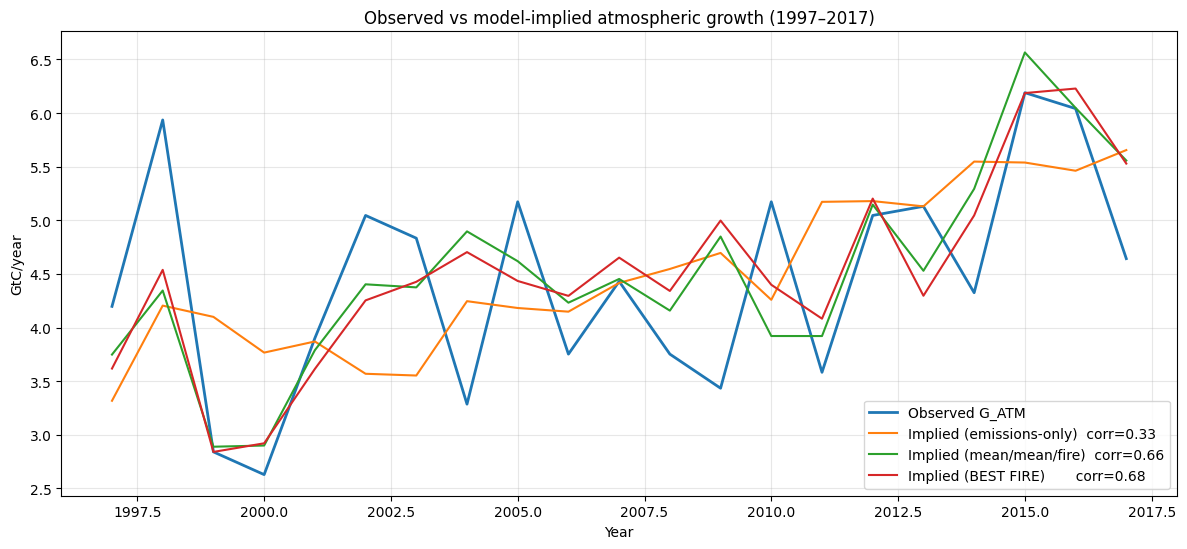

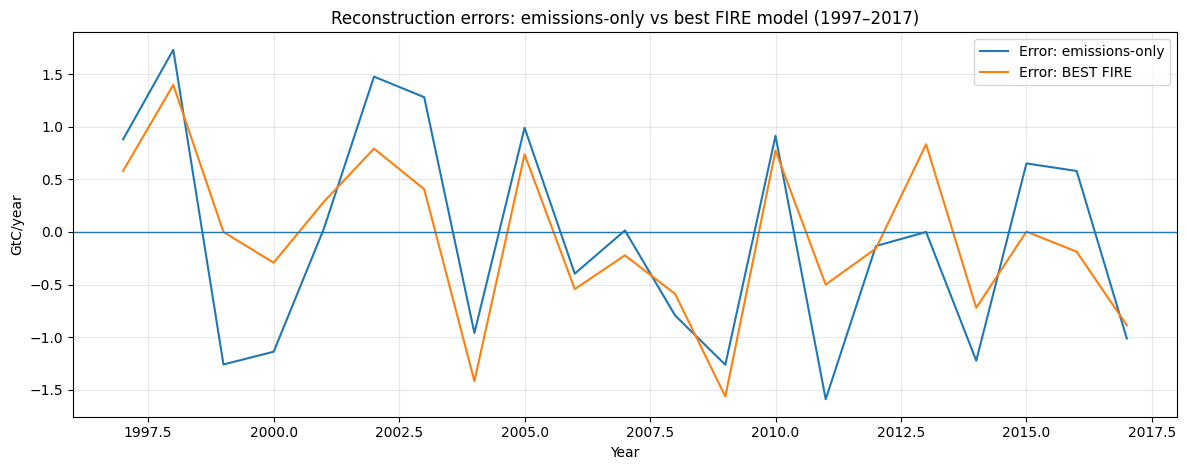

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

def fit_dyn(endog, exog):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1,0,0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def fit_ar1(endog):
    model = SARIMAX(
        endog=endog,
        order=(1,0,0),
        trend="n",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def implied_GATM(df_window, land_driver_cols, label=""):
    df_m = df_window.copy()

    need_cols = ["E_total", "dE_total", SOCN, SLND, BIM, GATM] + land_driver_cols
    df_m = df_m.dropna(subset=need_cols).copy()

    # ocean
    X_ocean = df_m[["E_total", "dE_total"]]
    res_ocn = fit_dyn(df_m[SOCN], X_ocean)
    df_m["S_OCN_hat"] = res_ocn.fittedvalues

    # land
    X_land = df_m[["E_total", "dE_total"] + land_driver_cols]
    res_lnd = fit_dyn(df_m[SLND], X_land)
    df_m["S_LND_hat"] = res_lnd.fittedvalues

    # imbalance
    res_bim = fit_ar1(df_m[BIM])
    df_m["BIM_hat"] = res_bim.fittedvalues

    # implied atmospheric growth
    df_m["G_ATM_hat"] = df_m["E_total"] - df_m["S_OCN_hat"] - df_m["S_LND_hat"] - df_m["BIM_hat"]
    df_m["G_ATM_err"] = df_m[GATM] - df_m["G_ATM_hat"]

    rmse = float(np.sqrt(np.mean(df_m["G_ATM_err"]**2)))
    mae  = float(np.mean(np.abs(df_m["G_ATM_err"])))
    corr = float(df_m[GATM].corr(df_m["G_ATM_hat"]))

    metrics = {"label": label, "n_obs": len(df_m), "rmse": rmse, "mae": mae, "corr": corr}
    return df_m[[YEAR, GATM, "G_ATM_hat"]].copy(), metrics


# -------------------------------------------------
# Window: 1997–2017 (fire exists)
# -------------------------------------------------
df_9717 = df_all[(df_all[YEAR] >= 1997) & (df_all[YEAR] <= 2017)].copy()

# 1) emissions-only baseline
df_base, m_base = implied_GATM(df_9717, land_driver_cols=[], label="Emissions-only baseline")

# 2) best fire spec from robustness table
best_cols = ["nino34_max_z", "scpdsi_global_mean_z", "DM_g_year_z"]
df_best, m_best = implied_GATM(df_9717, land_driver_cols=best_cols,
                               label="Best FIRE: nino_max + pdsi_mean + fire")

# 3) optional: mean/mean/fire baseline
mid_cols = ["nino34_mean_z", "scpdsi_global_mean_z", "DM_g_year_z"]
df_mid, m_mid = implied_GATM(df_9717, land_driver_cols=mid_cols,
                             label="FIRE baseline: nino_mean + pdsi_mean + fire")


# -------------------------------------------------
# Merge for plotting
# -------------------------------------------------
plot_df = df_base.merge(df_best[[YEAR, "G_ATM_hat"]], on=YEAR, how="inner", suffixes=("_base", "_best"))
plot_df = plot_df.merge(df_mid[[YEAR, "G_ATM_hat"]], on=YEAR, how="inner")
plot_df = plot_df.rename(columns={"G_ATM_hat": "G_ATM_hat_mid"})


# -------------------------------------------------
# Print metrics
# -------------------------------------------------
print("=== MODEL COMPARISON (1997–2017) ===")
for m in [m_base, m_mid, m_best]:
    print(f"{m['label']:45s} | Corr={m['corr']:.3f}  RMSE={m['rmse']:.3f}  MAE={m['mae']:.3f}  N={m['n_obs']}")

# -------------------------------------------------
# Plot 1: observed vs implied overlays
# -------------------------------------------------
plt.figure(figsize=(12, 5.6))
plt.plot(plot_df[YEAR], plot_df[GATM], label="Observed G_ATM", linewidth=2)
plt.plot(plot_df[YEAR], plot_df["G_ATM_hat_base"], label=f"Implied (emissions-only)  corr={m_base['corr']:.2f}")
plt.plot(plot_df[YEAR], plot_df["G_ATM_hat_mid"],  label=f"Implied (mean/mean/fire)  corr={m_mid['corr']:.2f}")
plt.plot(plot_df[YEAR], plot_df["G_ATM_hat_best"], label=f"Implied (BEST FIRE)       corr={m_best['corr']:.2f}")

plt.title("Observed vs model-implied atmospheric growth (1997–2017)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot 2: errors baseline vs best fire
# -------------------------------------------------
plot_df["err_base"] = plot_df[GATM] - plot_df["G_ATM_hat_base"]
plot_df["err_best"] = plot_df[GATM] - plot_df["G_ATM_hat_best"]

plt.figure(figsize=(12, 4.8))
plt.plot(plot_df[YEAR], plot_df["err_base"], label="Error: emissions-only")
plt.plot(plot_df[YEAR], plot_df["err_best"], label="Error: BEST FIRE")
plt.axhline(0, linewidth=1)
plt.title("Reconstruction errors: emissions-only vs best FIRE model (1997–2017)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

YEAR = "Year"
SOCN = "ocean sink"
SLND = "land sink"
GATM = "atmospheric growth"
BIM  = "budget imbalance"

def fit_dyn(endog, exog):
    model = SARIMAX(
        endog=endog,
        exog=exog,
        order=(1,0,0),
        trend="c",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def fit_ar1(endog):
    model = SARIMAX(
        endog=endog,
        order=(1,0,0),
        trend="n",
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    return model.fit(disp=False)

def implied_GATM(df_window, land_driver_cols, label=""):
    df_m = df_window.copy()
    need_cols = ["E_total", "dE_total", SOCN, SLND, BIM, GATM] + land_driver_cols
    df_m = df_m.dropna(subset=need_cols).copy()

    # ocean: emissions-only driver set
    X_ocean = df_m[["E_total", "dE_total"]]
    res_ocn = fit_dyn(df_m[SOCN], X_ocean)
    df_m["S_OCN_hat"] = res_ocn.fittedvalues

    # land: emissions + drivers
    X_land = df_m[["E_total", "dE_total"] + land_driver_cols]
    res_lnd = fit_dyn(df_m[SLND], X_land)
    df_m["S_LND_hat"] = res_lnd.fittedvalues

    # imbalance: AR(1)
    res_bim = fit_ar1(df_m[BIM])
    df_m["BIM_hat"] = res_bim.fittedvalues

    # implied atmospheric growth
    df_m["G_ATM_hat"] = df_m["E_total"] - df_m["S_OCN_hat"] - df_m["S_LND_hat"] - df_m["BIM_hat"]
    df_m["G_ATM_err"] = df_m[GATM] - df_m["G_ATM_hat"]

    rmse = float(np.sqrt(np.mean(df_m["G_ATM_err"]**2)))
    mae  = float(np.mean(np.abs(df_m["G_ATM_err"])))
    corr = float(df_m[GATM].corr(df_m["G_ATM_hat"]))

    # extract land coefficients for the added drivers (for interpretability)
    land_params = res_lnd.params
    driver_coefs = {f"coef_{c}": float(land_params.get(c, np.nan)) for c in land_driver_cols}

    metrics = {
        "spec": label,
        "n_obs": len(df_m),
        "rmse": rmse,
        "mae": mae,
        "corr": corr,
        **driver_coefs
    }
    return df_m[[YEAR, GATM, "G_ATM_hat"]].copy(), metrics


# -------------------------------------------------
# Overlap window: 1997–2012 (both tau and fire exist)
# -------------------------------------------------
df_9712 = df_all[(df_all[YEAR] >= 1997) & (df_all[YEAR] <= 2012)].copy()

# Core climate controls (choose mean or max; this is your “base climate” block)
ENSO = "nino34_max_z"              # consistent with your best in later period
PDSI = "scpdsi_global_mean_z"      # strongest in 1997–2017
FIRE = "DM_g_year_z"
TAU  = "tau_global_mean_z"

# -------------------------------------------------
# Nested specs (incremental testing)
# -------------------------------------------------
specs = [
    ("Emissions-only", []),

    ("+ ENSO + PDSI", [ENSO, PDSI]),

    ("+ ENSO + PDSI + FIRE", [ENSO, PDSI, FIRE]),

    ("+ ENSO + PDSI + TAU", [ENSO, PDSI, TAU]),

    ("+ ENSO + PDSI + FIRE + TAU", [ENSO, PDSI, FIRE, TAU]),
]

series_dict = {}
metrics_list = []

for label, drivers in specs:
    df_hat, m = implied_GATM(df_9712, land_driver_cols=drivers, label=label)
    series_dict[label] = df_hat
    metrics_list.append(m)

# -------------------------------------------------
# Results table
# -------------------------------------------------
tab = pd.DataFrame(metrics_list).sort_values("corr", ascending=False)

print("\n===== NESTED MODEL COMPARISON: 1997–2012 overlap =====")
cols_show = ["spec", "n_obs", "corr", "rmse", "mae"] + [c for c in tab.columns if c.startswith("coef_")]
print(tab[cols_show].to_string(index=False))


c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



===== NESTED MODEL COMPARISON: 1997–2012 overlap =====
                      spec  n_obs      corr     rmse      mae  coef_nino34_max_z  coef_scpdsi_global_mean_z  coef_DM_g_year_z  coef_tau_global_mean_z
       + ENSO + PDSI + TAU     16  0.589788 0.767415 0.588320          -0.544875                   0.382147               NaN                7.814551
      + ENSO + PDSI + FIRE     16  0.574828 0.774574 0.632071          -0.368312                   0.544815         -0.054545                     NaN
+ ENSO + PDSI + FIRE + TAU     16  0.573140 0.792289 0.664149          -0.342511                   0.588695         -0.085774               -0.012956
             + ENSO + PDSI     16  0.565836 0.781133 0.629413          -0.399686                   0.528280               NaN                     NaN
            Emissions-only     16 -0.026675 1.076903 0.948925                NaN                        NaN               NaN                     NaN


c:\Users\zgcha\Documents\Projects\Econometric Game\2019\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


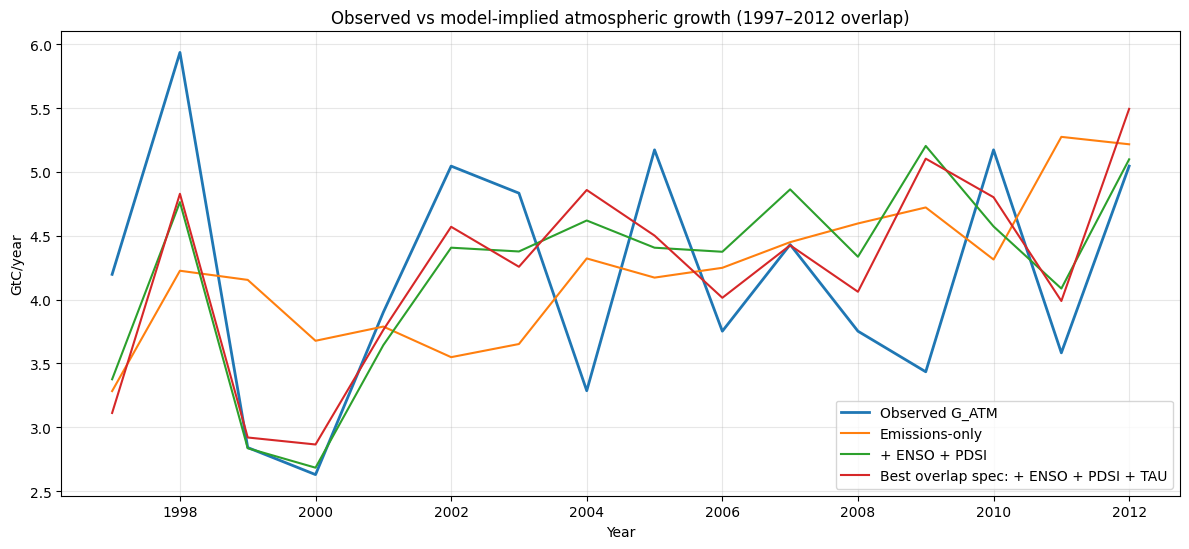

In [29]:
import matplotlib.pyplot as plt

# pick the best model and compare with climate-core and emissions-only
best_spec = tab.iloc[0]["spec"]
core_spec = "+ ENSO + PDSI"
base_spec = "Emissions-only"

# merge to plot
df_plot = series_dict[base_spec].merge(
    series_dict[core_spec][[YEAR, "G_ATM_hat"]],
    on=YEAR, how="inner", suffixes=("_base", "_core")
)

df_plot = df_plot.merge(
    series_dict[best_spec][[YEAR, "G_ATM_hat"]],
    on=YEAR, how="inner"
).rename(columns={"G_ATM_hat": "G_ATM_hat_best"})

plt.figure(figsize=(12, 5.6))
plt.plot(df_plot[YEAR], df_plot[GATM], label="Observed G_ATM", linewidth=2)
plt.plot(df_plot[YEAR], df_plot["G_ATM_hat_base"], label=base_spec)
plt.plot(df_plot[YEAR], df_plot["G_ATM_hat_core"], label=core_spec)
plt.plot(df_plot[YEAR], df_plot["G_ATM_hat_best"], label=f"Best overlap spec: {best_spec}")

plt.title("Observed vs model-implied atmospheric growth (1997–2012 overlap)")
plt.xlabel("Year")
plt.ylabel("GtC/year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
